## Setup

In [5]:
!pip uninstall -y mediapipe protobuf

In [2]:
!pip show protobuf

In [3]:
pip install --upgrade grpcio-status ydf


Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 0.0.0
ERROR: Could not find a version that satisfies the requirement ydf (from versions: none)
ERROR: No matching distribution found for ydf


In [4]:
!pip install -q mediapipe

ERROR: Could not find a version that satisfies the requirement mediapipe (from versions: none)
ERROR: No matching distribution found for mediapipe


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [ ]:
import cv2
from mediapipe.tasks.python.vision import HandLandmarkerResult

In [ ]:
from mediapipe.tasks.python.vision import PoseLandmarker, PoseLandmarkerOptions

In [ ]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
HandLandmarkerResult = mp.tasks.vision.HandLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

In [ ]:
hand_options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands = 2
)
pose_options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='pose_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    output_segmentation_masks=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Test mediapipe

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

In [ ]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [ ]:
def draw_pose_landmarks(rgb_image, pose_result):
    annotated_image = np.copy(rgb_image)

    if not pose_result.pose_landmarks:
        return annotated_image

    pose_landmarks = pose_result.pose_landmarks[0]

    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    # Iterate over the landmarks of the first pose
    pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for lm in pose_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        solutions.drawing_styles.get_default_pose_landmarks_style())

    return annotated_image

In [ ]:
cap = cv2.VideoCapture('/content/WIN_20250609_15_22_19_Pro.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ms_per_frame = int(1000/fps)
timestamp_ms = 0


29.89105969208607


In [ ]:
out = cv2.VideoWriter('output_with_landmarks.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (w, h))

In [ ]:
with HandLandmarker.create_from_options(hand_options) as hand_landmarker, \
     PoseLandmarker.create_from_options(pose_options) as pose_landmarker:

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            break
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        hand_result: HandLandmarkerResult = hand_landmarker.detect_for_video(mp_image, timestamp_ms)
        pose_result = pose_landmarker.detect_for_video(mp_image, timestamp_ms)
        timestamp_ms += ms_per_frame
        annotated_frame = draw_pose_landmarks(rgb_frame, pose_result)
        annotated_frame = draw_landmarks_on_image(annotated_frame, hand_result)

        bgr_annotated = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        out.write(bgr_annotated)

cap.release()
out.release()


Ignoring empty camera frame.


## **Data preparation**

In [ ]:
import os
from glob import glob

In [ ]:
# !mkdir /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe

In [ ]:
# !rm -rf /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy

In [ ]:
root_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe"
npy_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"
os.makedirs(npy_dir, exist_ok=True)

In [ ]:
def extract_landmarks_from_video(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Không thể mở video.")


        pose_detector = PoseLandmarker.create_from_options(pose_options)
        hand_detector = HandLandmarker.create_from_options(hand_options)

        pose_seq = []
        hand_seq = []
        frame_idx = 0

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)

            timestamp = frame_idx

            # Pose detection
            pose_result = pose_detector.detect_for_video(mp_image, timestamp)
            if pose_result.pose_landmarks:
                pose = np.array([[lm.x, lm.y, lm.z] for lm in pose_result.pose_landmarks[0]], dtype=np.float32)
            else:
                pose = np.zeros((33, 3), dtype=np.float32)
            pose_seq.append(pose)

            # Hand detection
            hand_result = hand_detector.detect_for_video(mp_image, timestamp)
            hands_frame = np.zeros((2, 21, 3), dtype=np.float32)
            for i, hand_landmarks in enumerate(hand_result.hand_landmarks[:2]):
                for j, lm in enumerate(hand_landmarks):
                    hands_frame[i, j] = [lm.x, lm.y, lm.z]
            hand_seq.append(hands_frame)

            frame_idx += 1

        cap.release()
        pose_seq = np.array(pose_seq)           # (T, 33, 3)
        hand_seq = np.array(hand_seq)           # (T, 2, 21, 3)

        combined = np.concatenate([
            pose_seq,                           # (T, 33, 3)
            hand_seq[:, 0],                     # Tay trái/phải 1
            hand_seq[:, 1]                      # Tay còn lại
        ], axis=1)                              # → (T, 75, 3)
        return combined

    except Exception as e:
        print(f"[ERROR] Failed to process {video_path}: {str(e)}")
        return None


In [ ]:
from tqdm.notebook import tqdm
video_paths = glob(os.path.join(root_dir, '*', 'rgb', '*avi'))
print(f"Found {len(video_paths)} video(s).")

for video_path in tqdm(video_paths, desc="Processing videos"):
    folder = video_path.split(os.sep)[-3]
    filename = os.path.splitext(os.path.basename(video_path))[0]
    landmark_path = os.path.join(npy_dir, folder, f"{filename}_landmarked.npy")

    os.makedirs(os.path.dirname(landmark_path), exist_ok=True)


    tqdm.write(f"Processing {video_path}...")
    landmarks = extract_landmarks_from_video(video_path)

    if landmarks is not None:
        np.save(landmark_path, landmarks)
        tqdm.write(f"Saved landmarks to {landmark_path}")
    else:
        tqdm.write(f"Skipped {video_path} due to error.")

Found 1014 video(s).


Processing videos:   0%|          | 0/1014 [00:00<?, ?it/s]

Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/298_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/298_A75P2__landmarked.npy
Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/225_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/225_A75P2__landmarked.npy
Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/517_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/517_A75P2__landmarked.npy
Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/584_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/584_A75P2__landmarked.npy
Processing /content/drive/MyDriv

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
def extract_subject_id(video_path):
    parts = video_path.split(os.sep)
    folder_name = parts[-2]  # e.g., A52P1
    if 'P' in folder_name:
        return folder_name.split('P')[-1]
    return None

def extract_action_id(video_path):
    parts = video_path.split(os.sep)
    folder_name = parts[-2]  # e.g., A52P1
    if 'P' in folder_name:
        return folder_name.split('P')[0]
    return None

# Tạo DataFrame từ video_paths
video_info = []
npy_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"
video_paths = glob(os.path.join(npy_dir, '*', '*.npy'))


for video_path in video_paths:
    subject_id = extract_subject_id(video_path)
    action_id = extract_action_id(video_path)
    video_info.append({
        'file_path': video_path,
        'label': action_id,
        'signer': subject_id
    })

df = pd.DataFrame(video_info)

unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
df['label'] = df['label'].map(label_map)

# Chia train/val signer không trùng nhau trong từng action
train_rows = []
val_rows = []

for label, group in df.groupby('label'):
    unique_signers = group['signer'].unique()

    if len(unique_signers) < 2:
        print(f"Bỏ qua label {label} vì có quá ít signer ({len(unique_signers)})")
        continue

    train_signers, val_signers = train_test_split(unique_signers, test_size=0.2, random_state=42)

    train_group = group[group['signer'].isin(train_signers)]
    val_group = group[group['signer'].isin(val_signers)]

    train_rows.append(train_group)
    val_rows.append(val_group)

# Gộp tất cả các label lại
train_df = pd.concat(train_rows, ignore_index=True)
val_df = pd.concat(val_rows, ignore_index=True)

# Lưu file corpus

train_df[['file_path', 'label']].to_csv(os.path.join(npy_dir,'train.corpus.csv'), index=False, header=True)
val_df[['file_path', 'label']].to_csv(os.path.join(npy_dir,'val.corpus.csv'), index=False, header=True)

print(f"Tổng số video train: {len(train_df)}")
print(f"Tổng số video val: {len(val_df)}")


Tổng số video train: 2135
Tổng số video val: 624


## Keypoint Overlay

In [ ]:
import cv2
import numpy as np
import os

def visualize_on_video(video_path, npy_path, label, output_path,
                       radius=4, color=(0, 255, 0), thickness=-1, font_scale=1.0, font_color=(0, 0, 255)):
    # Load keypoints (T, N, 2)
    keypoints_seq = np.load(npy_path)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError(f"Không mở được video: {video_path}")

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if len(keypoints_seq) != frame_count:
        print(f"Cảnh báo: số frame trong video ({frame_count}) ≠ keypoints ({len(keypoints_seq)}) → dùng min(T)")
    T = min(len(keypoints_seq), frame_count)

    # Output writer
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    out_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    for t in range(T):
        ret, frame = cap.read()
        if not ret:
            break

        keypoints = keypoints_seq[t]  # (N, 3)
        # Extract only the x and y coordinates
        keypoints_xy = keypoints[:, :2] # (N, 2)

        for x, y in keypoints_xy: # Iterate over (N, 2) array
            # Scale coordinates to image dimensions
            x = int(round(x * w))
            y = int(round(y * h))
            cv2.circle(frame, (x, y), radius, color, thickness)

        # Thêm nhãn vào góc trên trái
        cv2.putText(frame, f'Label: {label}', (20, 40),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=font_scale, color=font_color, thickness=2)

        out_writer.write(frame)

    cap.release()
    out_writer.release()
    print(f"Đã lưu video đã vẽ keypoints: {output_path}")

In [ ]:
video_path = '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe'
npy_path = '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy'

visualize_on_video(video_path, npy_path, label, output_path)


NameError: name 'output_path' is not defined

In [ ]:
from tqdm import tqdm
import zipfile
import os

def visualize_multiple_videos(data_list, output_dir, zip_output_path):
    os.makedirs(output_dir, exist_ok=True)
    output_paths = []

    print(f"🔧 Đang xử lý {len(data_list)} video...\n")

    for item in tqdm(data_list, desc="Tổng tiến trình", unit="video"):
        video_path = item["video_path"]
        npy_path = item["npy_path"]
        label = item["label"]

        video_name = os.path.splitext(os.path.basename(video_path))[0]
        relative_folder = os.path.basename(os.path.dirname(os.path.dirname(video_path)))
        output_path = os.path.join(output_dir, f"{relative_folder}_{video_name}_visualized.mp4")

        # Tiến trình từng bước
        try:
            tqdm.write(f"\nĐang xử lý: {video_name} (Label: {label})")

            tqdm.write(" Đọc keypoints...")
            keypoints_seq = np.load(npy_path)

            tqdm.write("Mở video...")
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                tqdm.write(f"Không mở được video: {video_path}")
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            T = min(len(keypoints_seq), frame_count)
            out_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

            frame_bar = tqdm(range(T), desc=f"  Vẽ {video_name}", leave=False)
            for t in frame_bar:
                ret, frame = cap.read()
                if not ret:
                    break
                keypoints = keypoints_seq[t][:, :2]
                for x, y in keypoints:
                    x = int(round(x * w))
                    y = int(round(y * h))
                    cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)
                cv2.putText(frame, f'Label: {label}', (20, 40),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=1.0, color=(0, 0, 255), thickness=2)
                out_writer.write(frame)

            cap.release()
            out_writer.release()
            output_paths.append(output_path)

        except Exception as e:
            tqdm.write(f"Lỗi khi xử lý {video_path}: {e}")

    tqdm.write("\nĐang nén các video đã xử lý...")
    with zipfile.ZipFile(zip_output_path, 'w') as zipf:
        for path in tqdm(output_paths, desc="🗜️ Nén", unit="file"):
            arcname = os.path.basename(path)
            zipf.write(path, arcname=arcname)

    tqdm.write(f"\nXong! File zip kết quả: {zip_output_path}")
    return zip_output_path

In [ ]:
import os

def build_data_list_with_custom_video_names(videos_root, keypoints_root):
    data_list = []

    for folder in os.listdir(videos_root):
        video_folder = os.path.join(videos_root, folder, 'rgb')
        keypoint_folder = os.path.join(keypoints_root, folder)

        if not os.path.isdir(video_folder) or not os.path.isdir(keypoint_folder):
            continue

        for file in os.listdir(video_folder):
            if not file.endswith(('.avi', '.mp4', '.mov')):
                continue

            video_path = os.path.join(video_folder, file)
            video_name = os.path.splitext(file)[0]  # bỏ đuôi .avi
            keypoint_name = f"{video_name}_landmarked.npy"
            keypoint_path = os.path.join(keypoint_folder, keypoint_name)

            if os.path.exists(keypoint_path):
                # Lấy label từ tên folder, ví dụ A51P1 → A51
                label = ''.join([c for c in folder if c.isalpha() or c.isdigit()]).rstrip('0123456789')

                data_list.append({
                    "video_path": video_path,
                    "npy_path": keypoint_path,
                    "label": label
                })
            else:
                print(f"Không tìm thấy keypoint cho video: {keypoint_path}")

    return data_list

In [ ]:
videos_root = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe"            # nơi chứa video: dataset/A51P1/rgb/video.avi
keypoints_root = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"       # nơi chứa landmark: landmarks/A51P1/video_landmark.npy

output_dir = "output_videos"
zip_path = "visualized_videos.zip"

data_list = build_data_list_with_custom_video_names(videos_root, keypoints_root)
zip_file = visualize_multiple_videos(data_list, output_dir, zip_path)

Đã lưu video đã vẽ keypoints: output_videos/298_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/225_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/517_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/584_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/406_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/457_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/31_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/156_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/350_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/99_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/298_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/200_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/30_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/447_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/398_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_v

In [ ]:
import os
import pandas as pd

def build_data_list_from_misclassified_csv(csv_path, videos_root):
    """
    Xây dựng data_list từ file CSV misclassified, với:
    - file_path: đường dẫn npy
    - ánh xạ ngược video_path tương ứng
    - kèm theo true_label, predicted_label, confidence

    Args:
        csv_path (str): CSV chứa file_path, true_label, predicted_label, confidence
        videos_root (str): thư mục gốc chứa video (vd: A51P1/rgb/...)

    Returns:
        list[dict]: mỗi item có video_path, npy_path, label, predicted_label, confidence
    """
    df = pd.read_csv(csv_path)
    data_list = []

    for _, row in df.iterrows():
        npy_path = row['file_path']
        folder = os.path.basename(os.path.dirname(npy_path))  # e.g. A51P1
        video_name = os.path.basename(npy_path).replace('_landmarked.npy', '')

        # Tìm video tương ứng trong thư mục gốc
        video_path = None
        for ext in ['.avi', '.mp4', '.mov']:
            candidate = os.path.join(videos_root, folder, 'rgb', f"{video_name}{ext}")
            if os.path.exists(candidate):
                video_path = candidate
                break

        if video_path is None:
            print(f"[⚠️] Không tìm thấy video tương ứng với {npy_path}")
            continue

        data_list.append({
            "video_path": video_path,
            "npy_path": npy_path,
            "label": row['true_label'],
            "predicted_label": row['predicted_label'],
            "confidence": row['confidence']
        })

    return data_list


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import zipfile
import os

def visualize_multiple_videos_1(data_list, output_dir, zip_output_path):
    os.makedirs(output_dir, exist_ok=True)
    output_paths = []

    print(f"🔧 Đang xử lý {len(data_list)} video...\n")

    for item in tqdm(data_list, desc="Tổng tiến trình", unit="video"):
        video_path = item["video_path"]
        npy_path = item["npy_path"]
        true_label = item.get("label", "N/A")
        predicted_label = item.get("predicted_label", "N/A")
        confidence = item.get("confidence", "N/A")

        video_name = os.path.splitext(os.path.basename(video_path))[0]
        relative_folder = os.path.basename(os.path.dirname(os.path.dirname(video_path)))
        output_path = os.path.join(output_dir, f"{relative_folder}_{video_name}_visualized.mp4")

        try:
            tqdm.write(f"\n Đang xử lý: {video_name} (True: {true_label}, Pred: {predicted_label}, Conf: {confidence})")

            tqdm.write(" Đọc keypoints...")
            keypoints_seq = np.load(npy_path)

            tqdm.write(" Mở video...")
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                tqdm.write(f"Không mở được video: {video_path}")
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            T = min(len(keypoints_seq), frame_count)
            out_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

            frame_bar = tqdm(range(T), desc=f" Vẽ {video_name}", leave=False)
            for t in frame_bar:
                ret, frame = cap.read()
                if not ret:
                    break
                keypoints = keypoints_seq[t][:, :2]
                for x, y in keypoints:
                    x = int(round(x * w))
                    y = int(round(y * h))
                    cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)

                # Hiển thị thông tin trên frame
                info_texts = [
                    f'True: {true_label}',
                    f'Pred: {predicted_label}',
                    f'Conf: {confidence:.4f}' if isinstance(confidence, float) else f'Conf: {confidence}'
                ]
                for i, text in enumerate(info_texts):
                    y_pos = 40 + i * 30
                    cv2.putText(frame, text, (20, y_pos),
                                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                fontScale=1.0, color=(0, 0, 255), thickness=2)

                out_writer.write(frame)

            cap.release()
            out_writer.release()
            output_paths.append(output_path)

        except Exception as e:
            tqdm.write(f" Lỗi khi xử lý {video_path}: {e}")

    tqdm.write("\nĐang nén các video đã xử lý...")
    with zipfile.ZipFile(zip_output_path, 'w') as zipf:
        for path in tqdm(output_paths, desc="🗜️ Nén", unit="file"):
            arcname = os.path.basename(path)
            zipf.write(path, arcname=arcname)

    tqdm.write(f"\n Xong! File zip kết quả: {zip_output_path}")
    return zip_output_path


In [ ]:
!rm -rf /content/output_videos

In [ ]:
videos_root = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe"            # nơi chứa video: dataset/A51P1/rgb/video.avi
keypoints_root = "misclassified.csv"

failed_output_dir = "failed_output_videos"
zip_path = "failed_visualized_videos.zip"

data_list = build_data_list_from_misclassified_csv(keypoints_root,videos_root)
zip_file = visualize_multiple_videos_1(data_list, output_dir, zip_path)

🔧 Đang xử lý 270 video...



📂 Tổng tiến trình:   0%|          | 0/270 [00:00<?, ?video/s]


📁 Đang xử lý: 968_A52P8_ (True: 0, Pred: 2, Conf: 0.3708134293556213)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   0%|          | 1/270 [00:00<01:00,  4.41video/s]


📁 Đang xử lý: 452_A52P8_ (True: 0, Pred: 2, Conf: 0.2052064687013626)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|          | 2/270 [00:00<01:08,  3.94video/s]


📁 Đang xử lý: 714_A52P8_ (True: 0, Pred: 10, Conf: 0.1811872273683548)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|          | 3/270 [00:00<01:07,  3.97video/s]


📁 Đang xử lý: 628_A52P8_ (True: 0, Pred: 10, Conf: 0.334516704082489)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|▏         | 4/270 [00:01<01:06,  4.00video/s]


📁 Đang xử lý: 888_A52P8_ (True: 0, Pred: 2, Conf: 0.3857580423355102)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   2%|▏         | 5/270 [00:01<01:04,  4.11video/s]


📁 Đang xử lý: 368_A52P8_ (True: 0, Pred: 10, Conf: 0.2165658324956894)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   2%|▏         | 6/270 [00:01<01:04,  4.12video/s]


📁 Đang xử lý: 282_A52P8_ (True: 0, Pred: 10, Conf: 0.6806480884552002)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 7/270 [00:01<01:04,  4.11video/s]


📁 Đang xử lý: 180_A52P8_ (True: 0, Pred: 2, Conf: 0.4673782289028168)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 8/270 [00:02<01:07,  3.87video/s]


📁 Đang xử lý: 543_A52P8_ (True: 0, Pred: 10, Conf: 0.1983865350484848)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 9/270 [00:02<01:06,  3.95video/s]


📁 Đang xử lý: 802_A52P8_ (True: 0, Pred: 10, Conf: 0.1935191750526428)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   4%|▎         | 10/270 [00:02<01:04,  4.00video/s]


📁 Đang xử lý: 804_A52P9_ (True: 0, Pred: 11, Conf: 0.4585944712162018)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   4%|▍         | 11/270 [00:02<01:04,  4.04video/s]


📁 Đang xử lý: 375_A52P9_ (True: 0, Pred: 11, Conf: 0.5637159943580627)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   4%|▍         | 12/270 [00:02<01:02,  4.10video/s]


📁 Đang xử lý: 886_A52P9_ (True: 0, Pred: 11, Conf: 0.5643452405929565)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   5%|▍         | 13/270 [00:03<01:02,  4.10video/s]


📁 Đang xử lý: 967_A52P9_ (True: 0, Pred: 7, Conf: 0.375764399766922)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   5%|▌         | 14/270 [00:03<01:02,  4.09video/s]


📁 Đang xử lý: 539_A52P9_ (True: 0, Pred: 2, Conf: 0.7286251187324524)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▌         | 15/270 [00:03<01:03,  4.03video/s]


📁 Đang xử lý: 717_A52P9_ (True: 0, Pred: 11, Conf: 0.4408373236656189)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▌         | 16/270 [00:03<01:03,  4.01video/s]


📁 Đang xử lý: 629_A52P9_ (True: 0, Pred: 2, Conf: 0.7689926028251648)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▋         | 17/270 [00:04<01:03,  3.99video/s]


📁 Đang xử lý: 1127_A52P9_ (True: 0, Pred: 11, Conf: 0.3154927492141723)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   7%|▋         | 18/270 [00:04<01:01,  4.08video/s]


📁 Đang xử lý: 1048_A52P9_ (True: 0, Pred: 11, Conf: 0.402317613363266)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   7%|▋         | 19/270 [00:04<01:01,  4.07video/s]


📁 Đang xử lý: 456_A52P9_ (True: 0, Pred: 11, Conf: 0.5873938798904419)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   7%|▋         | 20/270 [00:04<01:00,  4.12video/s]


📁 Đang xử lý: 597_A52P18_ (True: 0, Pred: 12, Conf: 0.5323978662490845)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   8%|▊         | 21/270 [00:05<01:02,  3.99video/s]


📁 Đang xử lý: 292_A53P21_ (True: 1, Pred: 5, Conf: 0.6563118100166321)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   8%|▊         | 22/270 [00:05<00:57,  4.30video/s]


📁 Đang xử lý: 536_A53P21_ (True: 1, Pred: 5, Conf: 0.6201016306877136)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   9%|▊         | 23/270 [00:05<00:54,  4.54video/s]


📁 Đang xử lý: 175_A53P21_ (True: 1, Pred: 5, Conf: 0.6953417062759399)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   9%|▉         | 24/270 [00:05<00:51,  4.82video/s]


📁 Đang xử lý: 658_A53P21_ (True: 1, Pred: 5, Conf: 0.6212913393974304)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   9%|▉         | 25/270 [00:05<00:50,  4.84video/s]


📁 Đang xử lý: 707_A56P11_ (True: 2, Pred: 4, Conf: 0.313832014799118)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|▉         | 26/270 [00:06<00:55,  4.41video/s]


📁 Đang xử lý: 250_A56P9_ (True: 2, Pred: 8, Conf: 0.3235454559326172)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|█         | 27/270 [00:06<00:54,  4.46video/s]


📁 Đang xử lý: 742_A56P9_ (True: 2, Pred: 9, Conf: 0.2129562646150589)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|█         | 28/270 [00:06<00:55,  4.37video/s]


📁 Đang xử lý: 822_A56P9_ (True: 2, Pred: 9, Conf: 0.2681459486484527)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  11%|█         | 29/270 [00:06<00:55,  4.36video/s]


📁 Đang xử lý: 410_A56P9_ (True: 2, Pred: 6, Conf: 0.248041883111)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  11%|█         | 30/270 [00:07<00:54,  4.40video/s]


📁 Đang xử lý: 324_A56P9_ (True: 2, Pred: 6, Conf: 0.2130551636219024)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  11%|█▏        | 31/270 [00:07<00:55,  4.29video/s]


📁 Đang xử lý: 976_A56P15_ (True: 2, Pred: 0, Conf: 0.4066917598247528)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  12%|█▏        | 32/270 [00:07<01:02,  3.84video/s]


📁 Đang xử lý: 776_A56P15_ (True: 2, Pred: 0, Conf: 0.8161696791648865)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  12%|█▏        | 33/270 [00:08<01:04,  3.70video/s]


📁 Đang xử lý: 1181_A56P15_ (True: 2, Pred: 0, Conf: 0.6699731945991516)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  13%|█▎        | 34/270 [00:08<01:04,  3.67video/s]


📁 Đang xử lý: 472_A56P7_ (True: 2, Pred: 4, Conf: 0.3162303268909454)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  13%|█▎        | 35/270 [00:08<01:04,  3.62video/s]


📁 Đang xử lý: 907_A56P7_ (True: 2, Pred: 4, Conf: 0.4059930145740509)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  13%|█▎        | 36/270 [00:08<01:05,  3.56video/s]


📁 Đang xử lý: 909_A57P8_ (True: 3, Pred: 1, Conf: 0.4099101126194)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▎        | 37/270 [00:09<01:03,  3.65video/s]


📁 Đang xử lý: 781_A57P8_ (True: 3, Pred: 1, Conf: 0.4245073795318603)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▍        | 38/270 [00:09<01:00,  3.83video/s]


📁 Đang xử lý: 691_A57P11_ (True: 3, Pred: 5, Conf: 0.4364934861660003)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▍        | 39/270 [00:09<00:58,  3.94video/s]


📁 Đang xử lý: 262_A57P11_ (True: 3, Pred: 1, Conf: 0.6931312084197998)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  15%|█▍        | 40/270 [00:09<00:47,  4.81video/s]


📁 Đang xử lý: 1431_A57P16_ (True: 3, Pred: 0, Conf: 0.7986897230148315)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  15%|█▌        | 41/270 [00:10<00:54,  4.22video/s]


📁 Đang xử lý: 652_A59P5_ (True: 4, Pred: 2, Conf: 0.545290470123291)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▌        | 42/270 [00:10<01:02,  3.65video/s]


📁 Đang xử lý: 1013_A59P5_ (True: 4, Pred: 2, Conf: 0.8454862236976624)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▌        | 43/270 [00:10<01:12,  3.13video/s]


📁 Đang xử lý: 1147_A59P5_ (True: 4, Pred: 2, Conf: 0.7007408142089844)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▋        | 44/270 [00:11<01:10,  3.21video/s]


📁 Đang xử lý: 891_A59P5_ (True: 4, Pred: 2, Conf: 0.8393867015838623)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  17%|█▋        | 45/270 [00:11<01:15,  2.99video/s]


📁 Đang xử lý: 1236_A59P5_ (True: 4, Pred: 2, Conf: 0.8376632928848267)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  17%|█▋        | 46/270 [00:11<01:14,  3.02video/s]


📁 Đang xử lý: 1337_A59P5_ (True: 4, Pred: 2, Conf: 0.807427167892456)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  17%|█▋        | 47/270 [00:12<01:12,  3.08video/s]


📁 Đang xử lý: 546_A59P5_ (True: 4, Pred: 2, Conf: 0.7473713159561157)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  18%|█▊        | 48/270 [00:12<01:12,  3.04video/s]


📁 Đang xử lý: 453_A59P5_ (True: 4, Pred: 2, Conf: 0.4937717318534851)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  18%|█▊        | 49/270 [00:12<01:10,  3.13video/s]


📁 Đang xử lý: 766_A59P5_ (True: 4, Pred: 2, Conf: 0.7706994414329529)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▊        | 50/270 [00:13<01:15,  2.92video/s]


📁 Đang xử lý: 247_A59P4_ (True: 4, Pred: 9, Conf: 0.3472004234790802)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▉        | 51/270 [00:13<01:23,  2.63video/s]


📁 Đang xử lý: 79_A59P4_ (True: 4, Pred: 8, Conf: 0.2814649641513824)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▉        | 52/270 [00:14<01:32,  2.35video/s]


📁 Đang xử lý: 394_A59P4_ (True: 4, Pred: 10, Conf: 0.7741946578025818)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  20%|█▉        | 53/270 [00:14<01:25,  2.53video/s]


📁 Đang xử lý: 158_A59P1_ (True: 4, Pred: 2, Conf: 0.3181729316711426)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  20%|██        | 54/270 [00:14<01:29,  2.42video/s]


📁 Đang xử lý: 720_A59P1_ (True: 4, Pred: 9, Conf: 0.3018642961978912)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  20%|██        | 55/270 [00:15<01:20,  2.67video/s]


📁 Đang xử lý: 798_A59P6_ (True: 4, Pred: 8, Conf: 0.3625838458538055)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██        | 56/270 [00:15<01:09,  3.08video/s]


📁 Đang xử lý: 656_A59P6_ (True: 4, Pred: 9, Conf: 0.3635341823101043)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██        | 57/270 [00:15<01:01,  3.47video/s]


📁 Đang xử lý: 866_A59P6_ (True: 4, Pred: 8, Conf: 0.3744421303272247)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██▏       | 58/270 [00:15<00:57,  3.67video/s]


📁 Đang xử lý: 512_A59P6_ (True: 4, Pred: 9, Conf: 0.4387994408607483)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  22%|██▏       | 59/270 [00:16<00:56,  3.77video/s]


📁 Đang xử lý: 723_A59P6_ (True: 4, Pred: 9, Conf: 0.4524415731430053)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  22%|██▏       | 60/270 [00:16<00:53,  3.91video/s]


📁 Đang xử lý: 305_A59P6_ (True: 4, Pred: 9, Conf: 0.3936329483985901)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 61/270 [00:16<00:50,  4.15video/s]


📁 Đang xử lý: 440_A59P6_ (True: 4, Pred: 9, Conf: 0.4530397057533264)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 62/270 [00:16<00:48,  4.26video/s]


📁 Đang xử lý: 373_A59P6_ (True: 4, Pred: 9, Conf: 0.3374055624008178)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 63/270 [00:16<00:46,  4.42video/s]


📁 Đang xử lý: 593_A59P6_ (True: 4, Pred: 8, Conf: 0.225861057639122)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  24%|██▎       | 64/270 [00:17<00:44,  4.59video/s]


📁 Đang xử lý: 943_A59P6_ (True: 4, Pred: 8, Conf: 0.3036448955535888)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  24%|██▎       | 64/270 [00:17<00:44,  4.59video/s]

  📷 Mở video...



📂 Tổng tiến trình:  24%|██▍       | 65/270 [00:17<00:47,  4.34video/s]


📁 Đang xử lý: 148_A61P5_ (True: 5, Pred: 1, Conf: 0.6229062080383301)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  24%|██▍       | 66/270 [00:17<00:46,  4.35video/s]


📁 Đang xử lý: 370_A61P5_ (True: 5, Pred: 3, Conf: 0.703528106212616)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  25%|██▍       | 67/270 [00:17<00:45,  4.47video/s]


📁 Đang xử lý: 295_A61P5_ (True: 5, Pred: 3, Conf: 0.6094576716423035)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  25%|██▌       | 68/270 [00:18<00:45,  4.43video/s]


📁 Đang xử lý: 439_A61P5_ (True: 5, Pred: 3, Conf: 0.5976788997650146)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  26%|██▌       | 69/270 [00:18<00:44,  4.50video/s]


📁 Đang xử lý: 750_A61P12_ (True: 5, Pred: 0, Conf: 0.7670528292655945)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  26%|██▌       | 70/270 [00:18<00:39,  5.04video/s]


📁 Đang xử lý: 705_A61P12_ (True: 5, Pred: 0, Conf: 0.8198504447937012)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  26%|██▋       | 71/270 [00:18<00:36,  5.45video/s]


📁 Đang xử lý: 537_A61P12_ (True: 5, Pred: 0, Conf: 0.7546536922454834)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 72/270 [00:18<00:36,  5.45video/s]


📁 Đang xử lý: 657_A61P12_ (True: 5, Pred: 3, Conf: 0.5136627554893494)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  27%|██▋       | 72/270 [00:18<00:36,  5.45video/s]

  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 73/270 [00:18<00:35,  5.54video/s]


📁 Đang xử lý: 595_A61P12_ (True: 5, Pred: 0, Conf: 0.7863473892211914)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 74/270 [00:19<00:36,  5.42video/s]


📁 Đang xử lý: 793_A61P12_ (True: 5, Pred: 0, Conf: 0.7822914123535156)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  28%|██▊       | 75/270 [00:19<00:39,  4.93video/s]


📁 Đang xử lý: 692_A61P11_ (True: 5, Pred: 1, Conf: 0.7250067591667175)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  28%|██▊       | 76/270 [00:19<00:41,  4.66video/s]


📁 Đang xử lý: 480_A61P11_ (True: 5, Pred: 1, Conf: 0.6337664127349854)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▊       | 77/270 [00:19<00:42,  4.51video/s]


📁 Đang xử lý: 165_A61P11_ (True: 5, Pred: 1, Conf: 0.5201391577720642)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▉       | 78/270 [00:20<00:51,  3.71video/s]


📁 Đang xử lý: 131_A61P10_ (True: 5, Pred: 1, Conf: 0.7270869612693787)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▉       | 79/270 [00:20<01:06,  2.88video/s]


📁 Đang xử lý: 764_A61P3_ (True: 5, Pred: 1, Conf: 0.509846031665802)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  30%|██▉       | 80/270 [00:21<00:58,  3.22video/s]


📁 Đang xử lý: 389_A61P3_ (True: 5, Pred: 1, Conf: 0.5779892802238464)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  30%|███       | 81/270 [00:21<01:01,  3.10video/s]


📁 Đang xử lý: 659_A62P13_ (True: 6, Pred: 2, Conf: 0.4697111546993255)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  30%|███       | 82/270 [00:21<00:57,  3.30video/s]


📁 Đang xử lý: 732_A62P13_ (True: 6, Pred: 9, Conf: 0.1741117537021637)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███       | 83/270 [00:21<00:52,  3.56video/s]


📁 Đang xử lý: 243_A62P13_ (True: 6, Pred: 0, Conf: 0.4306074976921081)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███       | 84/270 [00:22<00:45,  4.08video/s]


📁 Đang xử lý: 495_A62P13_ (True: 6, Pred: 8, Conf: 0.3331058919429779)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███▏      | 85/270 [00:22<00:45,  4.03video/s]


📁 Đang xử lý: 360_A62P13_ (True: 6, Pred: 2, Conf: 0.6019928455352783)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  32%|███▏      | 86/270 [00:22<00:58,  3.12video/s]


📁 Đang xử lý: 161_A62P13_ (True: 6, Pred: 10, Conf: 0.4811134338378906)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  32%|███▏      | 87/270 [00:23<00:59,  3.08video/s]


📁 Đang xử lý: 791_A62P13_ (True: 6, Pred: 8, Conf: 0.2282655984163284)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  33%|███▎      | 88/270 [00:23<00:56,  3.24video/s]


📁 Đang xử lý: 570_A62P13_ (True: 6, Pred: 2, Conf: 0.2412827014923095)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  33%|███▎      | 89/270 [00:23<00:56,  3.22video/s]


📁 Đang xử lý: 281_A62P13_ (True: 6, Pred: 2, Conf: 0.8283402323722839)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  33%|███▎      | 90/270 [00:23<00:54,  3.30video/s]


📁 Đang xử lý: 42_A62P13_ (True: 6, Pred: 8, Conf: 0.3330260217189789)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▎      | 91/270 [00:24<01:00,  2.97video/s]


📁 Đang xử lý: 567_A62P5_ (True: 6, Pred: 11, Conf: 0.4369140267372131)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▍      | 92/270 [00:24<00:55,  3.22video/s]


📁 Đang xử lý: 497_A62P5_ (True: 6, Pred: 0, Conf: 0.4434720873832702)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▍      | 93/270 [00:24<00:50,  3.51video/s]


📁 Đang xử lý: 422_A62P5_ (True: 6, Pred: 8, Conf: 0.2885246276855469)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  35%|███▍      | 94/270 [00:25<00:48,  3.66video/s]


📁 Đang xử lý: 645_A62P5_ (True: 6, Pred: 11, Conf: 0.3861282169818878)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  35%|███▌      | 95/270 [00:25<00:46,  3.78video/s]


📁 Đang xử lý: 68_A62P5_ (True: 6, Pred: 7, Conf: 0.5134271383285522)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▌      | 96/270 [00:25<00:43,  4.04video/s]


📁 Đang xử lý: 209_A62P5_ (True: 6, Pred: 13, Conf: 0.6501098871231079)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▌      | 97/270 [00:25<00:40,  4.24video/s]


📁 Đang xử lý: 343_A62P5_ (True: 6, Pred: 11, Conf: 0.3664093315601349)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▋      | 98/270 [00:26<00:41,  4.10video/s]


📁 Đang xử lý: 132_A62P5_ (True: 6, Pred: 12, Conf: 0.6886549592018127)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  37%|███▋      | 99/270 [00:26<00:42,  4.06video/s]


📁 Đang xử lý: 718_A62P5_ (True: 6, Pred: 11, Conf: 0.5318924784660339)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  37%|███▋      | 100/270 [00:26<00:41,  4.07video/s]


📁 Đang xử lý: 272_A62P5_ (True: 6, Pred: 0, Conf: 0.7463578581809998)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  37%|███▋      | 101/270 [00:26<00:40,  4.12video/s]


📁 Đang xử lý: 627_A62P16_ (True: 6, Pred: 8, Conf: 0.2745542228221893)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  38%|███▊      | 102/270 [00:26<00:40,  4.18video/s]


📁 Đang xử lý: 196_A62P16_ (True: 6, Pred: 9, Conf: 0.4017707407474518)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  38%|███▊      | 103/270 [00:27<00:39,  4.19video/s]


📁 Đang xử lý: 790_A62P16_ (True: 6, Pred: 8, Conf: 0.2894413471221924)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  39%|███▊      | 104/270 [00:27<00:39,  4.26video/s]


📁 Đang xử lý: 386_A62P16_ (True: 6, Pred: 4, Conf: 0.2725449800491333)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  39%|███▉      | 105/270 [00:27<00:40,  4.08video/s]


📁 Đang xử lý: 275_A62P16_ (True: 6, Pred: 4, Conf: 0.3868026733398437)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  39%|███▉      | 106/270 [00:28<00:44,  3.66video/s]


📁 Đang xử lý: 42_A62P16_ (True: 6, Pred: 9, Conf: 0.2523055672645569)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|███▉      | 107/270 [00:28<00:46,  3.51video/s]


📁 Đang xử lý: 542_A62P16_ (True: 6, Pred: 9, Conf: 0.2362950891256332)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|████      | 108/270 [00:28<00:45,  3.55video/s]


📁 Đang xử lý: 702_A62P16_ (True: 6, Pred: 4, Conf: 0.3184065222740173)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|████      | 109/270 [00:28<00:44,  3.61video/s]


📁 Đang xử lý: 472_A62P16_ (True: 6, Pred: 9, Conf: 0.3053533732891083)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  41%|████      | 110/270 [00:29<00:41,  3.82video/s]


📁 Đang xử lý: 770_A62P6_ (True: 6, Pred: 9, Conf: 0.34708172082901)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  41%|████      | 111/270 [00:29<00:40,  3.88video/s]


📁 Đang xử lý: 375_A62P6_ (True: 6, Pred: 8, Conf: 0.3441742956638336)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  41%|████▏     | 112/270 [00:29<00:39,  4.05video/s]


📁 Đang xử lý: 308_A62P6_ (True: 6, Pred: 8, Conf: 0.3851751685142517)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  42%|████▏     | 113/270 [00:29<00:37,  4.22video/s]


📁 Đang xử lý: 687_A62P6_ (True: 6, Pred: 8, Conf: 0.2719711661338806)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  42%|████▏     | 114/270 [00:30<00:37,  4.13video/s]


📁 Đang xử lý: 447_A62P6_ (True: 6, Pred: 8, Conf: 0.3617096543312073)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  43%|████▎     | 115/270 [00:30<00:36,  4.24video/s]


📁 Đang xử lý: 1029_A62P6_ (True: 6, Pred: 8, Conf: 0.3114239275455475)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  43%|████▎     | 116/270 [00:30<00:39,  3.90video/s]


📁 Đang xử lý: 854_A62P6_ (True: 6, Pred: 9, Conf: 0.2219695150852203)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  43%|████▎     | 117/270 [00:30<00:39,  3.89video/s]


📁 Đang xử lý: 939_A62P6_ (True: 6, Pred: 8, Conf: 0.2221988439559936)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▎     | 118/270 [00:31<00:39,  3.84video/s]


📁 Đang xử lý: 432_A63P17_ (True: 7, Pred: 6, Conf: 0.3292892873287201)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▍     | 119/270 [00:31<00:34,  4.37video/s]


📁 Đang xử lý: 479_A63P17_ (True: 7, Pred: 8, Conf: 0.3329062759876251)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▍     | 120/270 [00:31<00:32,  4.69video/s]


📁 Đang xử lý: 339_A63P17_ (True: 7, Pred: 9, Conf: 0.3012240827083587)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  45%|████▍     | 121/270 [00:31<00:28,  5.26video/s]


📁 Đang xử lý: 240_A63P17_ (True: 7, Pred: 6, Conf: 0.3213371634483337)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  45%|████▌     | 122/270 [00:31<00:27,  5.47video/s]


📁 Đang xử lý: 532_A63P17_ (True: 7, Pred: 8, Conf: 0.3118890225887298)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  46%|████▌     | 123/270 [00:31<00:26,  5.54video/s]


📁 Đang xử lý: 39_A63P17_ (True: 7, Pred: 10, Conf: 0.7039868235588074)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  46%|████▌     | 124/270 [00:32<00:32,  4.54video/s]


📁 Đang xử lý: 188_A63P17_ (True: 7, Pred: 6, Conf: 0.3173209130764007)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  46%|████▋     | 125/270 [00:32<00:29,  4.87video/s]


📁 Đang xử lý: 1000_A63P14_ (True: 7, Pred: 8, Conf: 0.3772766292095184)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 126/270 [00:32<00:30,  4.75video/s]


📁 Đang xử lý: 392_A63P14_ (True: 7, Pred: 6, Conf: 0.3142763972282409)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 127/270 [00:32<00:30,  4.64video/s]


📁 Đang xử lý: 1062_A63P14_ (True: 7, Pred: 8, Conf: 0.3469805121421814)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 128/270 [00:33<00:31,  4.56video/s]


📁 Đang xử lý: 769_A63P14_ (True: 7, Pred: 2, Conf: 0.3461588621139526)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  48%|████▊     | 129/270 [00:33<00:32,  4.33video/s]


📁 Đang xử lý: 504_A63P14_ (True: 7, Pred: 2, Conf: 0.8380107283592224)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  48%|████▊     | 130/270 [00:33<00:45,  3.04video/s]


📁 Đang xử lý: 449_A63P14_ (True: 7, Pred: 8, Conf: 0.3963095545768738)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▊     | 131/270 [00:34<00:40,  3.41video/s]


📁 Đang xử lý: 704_A63P14_ (True: 7, Pred: 8, Conf: 0.3370687365531921)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▉     | 132/270 [00:34<00:38,  3.60video/s]


📁 Đang xử lý: 661_A63P14_ (True: 7, Pred: 9, Conf: 0.2991639375686645)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▉     | 133/270 [00:34<00:33,  4.04video/s]


📁 Đang xử lý: 580_A65P5_ (True: 8, Pred: 0, Conf: 0.4294074177742004)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  50%|████▉     | 134/270 [00:34<00:33,  4.11video/s]


📁 Đang xử lý: 113_A65P5_ (True: 8, Pred: 6, Conf: 0.308480829000473)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  50%|█████     | 135/270 [00:35<00:33,  4.04video/s]


📁 Đang xử lý: 346_A65P5_ (True: 8, Pred: 11, Conf: 0.4567209780216217)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  50%|█████     | 136/270 [00:35<00:32,  4.10video/s]


📁 Đang xử lý: 196_A65P5_ (True: 8, Pred: 0, Conf: 0.6220446825027466)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████     | 137/270 [00:35<00:31,  4.28video/s]


📁 Đang xử lý: 731_A65P5_ (True: 8, Pred: 0, Conf: 0.4335081875324249)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████     | 138/270 [00:35<00:31,  4.24video/s]


📁 Đang xử lý: 260_A65P5_ (True: 8, Pred: 6, Conf: 0.2539371252059936)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████▏    | 139/270 [00:35<00:32,  4.07video/s]


📁 Đang xử lý: 496_A65P5_ (True: 8, Pred: 6, Conf: 0.2786523103713989)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  52%|█████▏    | 140/270 [00:36<00:32,  3.96video/s]


📁 Đang xử lý: 655_A65P5_ (True: 8, Pred: 11, Conf: 0.2780673205852508)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  52%|█████▏    | 141/270 [00:36<00:32,  4.02video/s]


📁 Đang xử lý: 46_A65P5_ (True: 8, Pred: 0, Conf: 0.4885371625423431)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 142/270 [00:36<00:30,  4.22video/s]


📁 Đang xử lý: 422_A65P5_ (True: 8, Pred: 0, Conf: 0.3322068750858307)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 143/270 [00:36<00:29,  4.26video/s]


📁 Đang xử lý: 382_A65P9_ (True: 8, Pred: 13, Conf: 0.8950802683830261)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 144/270 [00:37<00:30,  4.17video/s]


📁 Đang xử lý: 659_A65P9_ (True: 8, Pred: 13, Conf: 0.4627111554145813)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  54%|█████▎    | 145/270 [00:37<00:29,  4.17video/s]


📁 Đang xử lý: 591_A65P9_ (True: 8, Pred: 13, Conf: 0.7066697478294373)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  54%|█████▍    | 146/270 [00:37<00:29,  4.22video/s]


📁 Đang xử lý: 316_A65P9_ (True: 8, Pred: 13, Conf: 0.914033055305481)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  54%|█████▍    | 147/270 [00:37<00:28,  4.28video/s]


📁 Đang xử lý: 457_A65P9_ (True: 8, Pred: 13, Conf: 0.9020918607711792)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  55%|█████▍    | 148/270 [00:38<00:28,  4.26video/s]


📁 Đang xử lý: 33_A65P9_ (True: 8, Pred: 13, Conf: 0.9062955379486084)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  55%|█████▌    | 149/270 [00:38<00:25,  4.77video/s]


📁 Đang xử lý: 527_A65P9_ (True: 8, Pred: 13, Conf: 0.8647720217704773)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▌    | 150/270 [00:38<00:25,  4.73video/s]


📁 Đang xử lý: 141_A65P9_ (True: 8, Pred: 13, Conf: 0.918386936187744)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▌    | 151/270 [00:38<00:29,  4.10video/s]


📁 Đang xử lý: 236_A65P9_ (True: 8, Pred: 13, Conf: 0.8164761066436768)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▋    | 152/270 [00:39<00:29,  4.00video/s]


📁 Đang xử lý: 72_A65P9_ (True: 8, Pred: 13, Conf: 0.9347684979438782)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  57%|█████▋    | 153/270 [00:39<00:28,  4.08video/s]


📁 Đang xử lý: 1015_A65P12_ (True: 8, Pred: 9, Conf: 0.4462263882160187)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  57%|█████▋    | 154/270 [00:39<00:29,  3.95video/s]


📁 Đang xử lý: 1264_A65P12_ (True: 8, Pred: 9, Conf: 0.3772439658641815)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  57%|█████▋    | 155/270 [00:39<00:28,  4.07video/s]


📁 Đang xử lý: 513_A65P12_ (True: 8, Pred: 6, Conf: 0.3473660945892334)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  58%|█████▊    | 156/270 [00:40<00:27,  4.17video/s]


📁 Đang xử lý: 949_A65P12_ (True: 8, Pred: 9, Conf: 0.4091417193412781)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  58%|█████▊    | 157/270 [00:40<00:26,  4.30video/s]


📁 Đang xử lý: 581_A65P12_ (True: 8, Pred: 7, Conf: 0.4195698797702789)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  59%|█████▊    | 158/270 [00:40<00:28,  3.93video/s]


📁 Đang xử lý: 1399_A65P12_ (True: 8, Pred: 9, Conf: 0.452172040939331)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  59%|█████▉    | 159/270 [00:40<00:31,  3.55video/s]


📁 Đang xử lý: 1336_A65P12_ (True: 8, Pred: 7, Conf: 0.347574919462204)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  59%|█████▉    | 160/270 [00:41<00:28,  3.85video/s]


📁 Đang xử lý: 1182_A65P12_ (True: 8, Pred: 9, Conf: 0.4291800856590271)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|█████▉    | 161/270 [00:41<00:28,  3.79video/s]


📁 Đang xử lý: 856_A65P12_ (True: 8, Pred: 9, Conf: 0.4145821928977966)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|██████    | 162/270 [00:41<00:29,  3.61video/s]


📁 Đang xử lý: 235_A65P17_ (True: 8, Pred: 10, Conf: 0.7915683388710022)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|██████    | 163/270 [00:41<00:25,  4.22video/s]


📁 Đang xử lý: 146_A65P17_ (True: 8, Pred: 6, Conf: 0.3348510563373565)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  61%|██████    | 164/270 [00:41<00:22,  4.81video/s]


📁 Đang xử lý: 430_A65P17_ (True: 8, Pred: 10, Conf: 0.7934008836746216)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  61%|██████    | 165/270 [00:42<00:21,  4.98video/s]


📁 Đang xử lý: 134_A66P14_ (True: 9, Pred: 2, Conf: 0.2951600551605224)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  61%|██████▏   | 166/270 [00:42<00:21,  4.92video/s]


📁 Đang xử lý: 590_A66P14_ (True: 9, Pred: 7, Conf: 0.369764506816864)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  62%|██████▏   | 167/270 [00:42<00:21,  4.82video/s]


📁 Đang xử lý: 460_A66P14_ (True: 9, Pred: 6, Conf: 0.3278490006923675)
  📥 Đọc keypoints...
  📷 Mở video...



  ✏️ Vẽ 460_A66P14_:  57%|█████▋    | 35/61 [00:00<00:00, 342.36it/s]



📁 Đang xử lý: 319_A66P14_ (True: 9, Pred: 7, Conf: 0.3643182516098022)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  62%|██████▏   | 168/270 [00:42<00:20,  4.91video/s]

  📷 Mở video...



📂 Tổng tiến trình:  63%|██████▎   | 169/270 [00:42<00:21,  4.75video/s]


📁 Đang xử lý: 194_A66P14_ (True: 9, Pred: 6, Conf: 0.2767879664897918)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  63%|██████▎   | 170/270 [00:43<00:20,  4.80video/s]


📁 Đang xử lý: 521_A66P14_ (True: 9, Pred: 6, Conf: 0.2397405505180359)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  63%|██████▎   | 171/270 [00:43<00:21,  4.70video/s]


📁 Đang xử lý: 389_A66P14_ (True: 9, Pred: 7, Conf: 0.3928628265857696)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▎   | 172/270 [00:43<00:21,  4.60video/s]


📁 Đang xử lý: 70_A66P14_ (True: 9, Pred: 4, Conf: 0.5003419518470764)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▍   | 173/270 [00:43<00:20,  4.62video/s]


📁 Đang xử lý: 652_A66P14_ (True: 9, Pred: 4, Conf: 0.4029886722564697)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▍   | 174/270 [00:44<00:22,  4.36video/s]


📁 Đang xử lý: 1248_A66P13_ (True: 9, Pred: 4, Conf: 0.3350770473480224)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  65%|██████▍   | 175/270 [00:44<00:22,  4.14video/s]


📁 Đang xử lý: 888_A66P13_ (True: 9, Pred: 2, Conf: 0.2633256018161773)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  65%|██████▌   | 176/270 [00:44<00:24,  3.87video/s]


📁 Đang xử lý: 652_A66P13_ (True: 9, Pred: 4, Conf: 0.3266659677028656)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▌   | 177/270 [00:44<00:23,  3.92video/s]


📁 Đang xử lý: 1335_A66P13_ (True: 9, Pred: 4, Conf: 0.3046181201934814)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▌   | 178/270 [00:45<00:24,  3.81video/s]


📁 Đang xử lý: 1158_A66P13_ (True: 9, Pred: 4, Conf: 0.324923038482666)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▋   | 179/270 [00:45<00:24,  3.67video/s]


📁 Đang xử lý: 573_A66P13_ (True: 9, Pred: 4, Conf: 0.265697568655014)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  67%|██████▋   | 180/270 [00:45<00:23,  3.76video/s]


📁 Đang xử lý: 444_A66P13_ (True: 9, Pred: 4, Conf: 0.3002327382564544)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  67%|██████▋   | 181/270 [00:46<00:27,  3.25video/s]


📁 Đang xử lý: 408_A66P15_ (True: 9, Pred: 4, Conf: 0.3246229290962219)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  67%|██████▋   | 182/270 [00:46<00:25,  3.42video/s]


📁 Đang xử lý: 329_A66P15_ (True: 9, Pred: 4, Conf: 0.4097451269626617)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  68%|██████▊   | 183/270 [00:46<00:25,  3.46video/s]


📁 Đang xử lý: 126_A66P15_ (True: 9, Pred: 10, Conf: 0.2665325701236725)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  68%|██████▊   | 184/270 [00:47<00:25,  3.42video/s]


📁 Đang xử lý: 222_A66P15_ (True: 9, Pred: 4, Conf: 0.4030652344226837)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▊   | 185/270 [00:47<00:25,  3.35video/s]


📁 Đang xử lý: 594_A66P15_ (True: 9, Pred: 2, Conf: 0.6425678730010986)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▉   | 186/270 [00:47<00:24,  3.42video/s]


📁 Đang xử lý: 490_A66P15_ (True: 9, Pred: 2, Conf: 0.3730693757534027)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▉   | 187/270 [00:47<00:25,  3.32video/s]


📁 Đang xử lý: 835_A66P15_ (True: 9, Pred: 4, Conf: 0.3782317340373993)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  70%|██████▉   | 188/270 [00:48<00:24,  3.29video/s]


📁 Đang xử lý: 934_A66P15_ (True: 9, Pred: 4, Conf: 0.4440321922302246)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  70%|███████   | 189/270 [00:48<00:24,  3.27video/s]


📁 Đang xử lý: 193_A66P6_ (True: 9, Pred: 8, Conf: 0.2699624598026275)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  70%|███████   | 190/270 [00:48<00:21,  3.79video/s]


📁 Đang xử lý: 634_A66P6_ (True: 9, Pred: 8, Conf: 0.3686810731887817)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████   | 191/270 [00:48<00:19,  4.03video/s]


📁 Đang xử lý: 773_A66P6_ (True: 9, Pred: 8, Conf: 0.4097347557544708)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████   | 192/270 [00:49<00:18,  4.25video/s]


📁 Đang xử lý: 359_A66P6_ (True: 9, Pred: 8, Conf: 0.4014939069747925)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████▏  | 193/270 [00:49<00:17,  4.39video/s]


📁 Đang xử lý: 426_A66P6_ (True: 9, Pred: 8, Conf: 0.4134814739227295)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  72%|███████▏  | 194/270 [00:49<00:16,  4.53video/s]


📁 Đang xử lý: 298_A66P6_ (True: 9, Pred: 8, Conf: 0.4189759790897369)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  72%|███████▏  | 195/270 [00:49<00:15,  4.69video/s]


📁 Đang xử lý: 237_A66P6_ (True: 9, Pred: 8, Conf: 0.3774994611740112)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  72%|███████▏  | 195/270 [00:49<00:15,  4.69video/s]

  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 196/270 [00:49<00:15,  4.82video/s]


📁 Đang xử lý: 360_A70P11_ (True: 10, Pred: 8, Conf: 0.3787084817886352)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  73%|███████▎  | 196/270 [00:49<00:15,  4.82video/s]

  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 197/270 [00:50<00:17,  4.09video/s]


📁 Đang xử lý: 734_A70P18_ (True: 10, Pred: 9, Conf: 0.4547267556190491)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 198/270 [00:50<00:19,  3.62video/s]


📁 Đang xử lý: 22_A70P18_ (True: 10, Pred: 7, Conf: 0.3945981562137604)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  74%|███████▎  | 199/270 [00:50<00:16,  4.41video/s]


📁 Đang xử lý: 218_A70P18_ (True: 10, Pred: 9, Conf: 0.4178280234336853)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  74%|███████▍  | 200/270 [00:50<00:14,  4.99video/s]


📁 Đang xử lý: 488_A70P18_ (True: 10, Pred: 9, Conf: 0.4132943749427795)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  74%|███████▍  | 201/270 [00:51<00:18,  3.72video/s]


📁 Đang xử lý: 1090_A70P18_ (True: 10, Pred: 9, Conf: 0.414265900850296)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  75%|███████▍  | 202/270 [00:51<00:20,  3.37video/s]


📁 Đang xử lý: 845_A70P18_ (True: 10, Pred: 8, Conf: 0.3699471056461334)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  75%|███████▌  | 203/270 [00:52<00:22,  2.92video/s]


📁 Đang xử lý: 990_A70P18_ (True: 10, Pred: 9, Conf: 0.3440526127815246)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  76%|███████▌  | 204/270 [00:52<00:22,  2.93video/s]


📁 Đang xử lý: 258_A70P18_ (True: 10, Pred: 4, Conf: 0.4116115868091583)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  76%|███████▌  | 205/270 [00:52<00:22,  2.92video/s]


📁 Đang xử lý: 631_A70P18_ (True: 10, Pred: 9, Conf: 0.4184845387935638)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  76%|███████▋  | 206/270 [00:53<00:21,  2.96video/s]


📁 Đang xử lý: 363_A70P18_ (True: 10, Pred: 4, Conf: 0.4124889969825744)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 207/270 [00:53<00:21,  2.86video/s]


📁 Đang xử lý: 83_A70P21_ (True: 10, Pred: 9, Conf: 0.2743724286556244)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 208/270 [00:53<00:19,  3.25video/s]


📁 Đang xử lý: 489_A70P21_ (True: 10, Pred: 2, Conf: 0.4460680186748504)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 209/270 [00:53<00:17,  3.47video/s]


📁 Đang xử lý: 222_A70P21_ (True: 10, Pred: 8, Conf: 0.3246180713176727)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  78%|███████▊  | 210/270 [00:54<00:15,  3.83video/s]


📁 Đang xử lý: 150_A70P21_ (True: 10, Pred: 9, Conf: 0.3285220861434936)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  78%|███████▊  | 210/270 [00:54<00:15,  3.83video/s]

  📷 Mở video...



📂 Tổng tiến trình:  78%|███████▊  | 211/270 [00:54<00:14,  3.98video/s]


📁 Đang xử lý: 631_A70P21_ (True: 10, Pred: 9, Conf: 0.2918876111507416)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▊  | 212/270 [00:54<00:14,  4.13video/s]


📁 Đang xử lý: 420_A70P21_ (True: 10, Pred: 8, Conf: 0.2661894857883453)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▉  | 213/270 [00:54<00:13,  4.23video/s]


📁 Đang xử lý: 285_A70P21_ (True: 10, Pred: 9, Conf: 0.2971659004688263)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▉  | 214/270 [00:55<00:13,  4.24video/s]


📁 Đang xử lý: 29_A70P21_ (True: 10, Pred: 4, Conf: 0.280176967382431)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  80%|███████▉  | 215/270 [00:55<00:12,  4.58video/s]


📁 Đang xử lý: 569_A70P21_ (True: 10, Pred: 8, Conf: 0.3509686887264251)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  80%|████████  | 216/270 [00:55<00:11,  4.71video/s]


📁 Đang xử lý: 360_A70P21_ (True: 10, Pred: 8, Conf: 0.3964542150497436)
  📥 Đọc keypoints...


📂 Tổng tiến trình:  80%|████████  | 216/270 [00:55<00:11,  4.71video/s]

  📷 Mở video...



📂 Tổng tiến trình:  80%|████████  | 217/270 [00:55<00:11,  4.73video/s]


📁 Đang xử lý: 303_A72P5_ (True: 11, Pred: 0, Conf: 0.3314191997051239)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████  | 218/270 [00:55<00:11,  4.61video/s]


📁 Đang xử lý: 756_A72P5_ (True: 11, Pred: 12, Conf: 0.308906227350235)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████  | 219/270 [00:56<00:11,  4.49video/s]


📁 Đang xử lý: 537_A72P5_ (True: 11, Pred: 0, Conf: 0.3383992314338684)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████▏ | 220/270 [00:56<00:11,  4.35video/s]


📁 Đang xử lý: 829_A72P5_ (True: 11, Pred: 0, Conf: 0.4192760288715362)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  82%|████████▏ | 221/270 [00:56<00:12,  4.07video/s]


📁 Đang xử lý: 222_A72P5_ (True: 11, Pred: 0, Conf: 0.3404612243175506)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  82%|████████▏ | 222/270 [00:56<00:11,  4.05video/s]


📁 Đang xử lý: 673_A72P5_ (True: 11, Pred: 0, Conf: 0.3484100103378296)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  83%|████████▎ | 223/270 [00:57<00:11,  4.00video/s]


📁 Đang xử lý: 616_A72P5_ (True: 11, Pred: 12, Conf: 0.6605538725852966)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  83%|████████▎ | 224/270 [00:57<00:10,  4.31video/s]


📁 Đang xử lý: 348_A72P9_ (True: 11, Pred: 13, Conf: 0.4265292882919311)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  83%|████████▎ | 225/270 [00:57<00:11,  4.01video/s]


📁 Đang xử lý: 2305_A72P19_ (True: 11, Pred: 12, Conf: 0.8154712915420532)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▎ | 226/270 [00:57<00:10,  4.17video/s]


📁 Đang xử lý: 2707_A72P19_ (True: 11, Pred: 0, Conf: 0.4329770505428314)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▍ | 227/270 [00:58<00:10,  4.17video/s]


📁 Đang xử lý: 1993_A72P19_ (True: 11, Pred: 4, Conf: 0.3218052983283996)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▍ | 228/270 [00:58<00:13,  3.20video/s]


📁 Đang xử lý: 2377_A72P19_ (True: 11, Pred: 12, Conf: 0.7645497918128967)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  85%|████████▍ | 229/270 [00:58<00:11,  3.48video/s]


📁 Đang xử lý: 2622_A72P19_ (True: 11, Pred: 12, Conf: 0.7385092973709106)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  85%|████████▌ | 230/270 [00:59<00:10,  3.64video/s]


📁 Đang xử lý: 2534_A72P19_ (True: 11, Pred: 12, Conf: 0.6263688206672668)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▌ | 231/270 [00:59<00:10,  3.69video/s]


📁 Đang xử lý: 815_A72P6_ (True: 11, Pred: 0, Conf: 0.7313753366470337)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▌ | 232/270 [00:59<00:09,  3.82video/s]


📁 Đang xử lý: 1234_A72P6_ (True: 11, Pred: 0, Conf: 0.698587954044342)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▋ | 233/270 [00:59<00:09,  3.85video/s]


📁 Đang xử lý: 1150_A72P6_ (True: 11, Pred: 12, Conf: 0.5001017451286316)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  87%|████████▋ | 234/270 [01:00<00:09,  3.81video/s]


📁 Đang xử lý: 1510_A72P6_ (True: 11, Pred: 12, Conf: 0.7537364363670349)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  87%|████████▋ | 235/270 [01:00<00:09,  3.78video/s]


📁 Đang xử lý: 690_A72P6_ (True: 11, Pred: 0, Conf: 0.8185872435569763)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  87%|████████▋ | 236/270 [01:00<00:10,  3.34video/s]


📁 Đang xử lý: 890_A72P6_ (True: 11, Pred: 12, Conf: 0.5799192190170288)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  88%|████████▊ | 237/270 [01:00<00:09,  3.45video/s]


📁 Đang xử lý: 1312_A72P6_ (True: 11, Pred: 12, Conf: 0.7640210390090942)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  88%|████████▊ | 238/270 [01:01<00:08,  3.57video/s]


📁 Đang xử lý: 976_A72P6_ (True: 11, Pred: 0, Conf: 0.8276035785675049)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  89%|████████▊ | 239/270 [01:01<00:08,  3.61video/s]


📁 Đang xử lý: 1062_A72P6_ (True: 11, Pred: 0, Conf: 0.6842531561851501)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  89%|████████▉ | 240/270 [01:01<00:08,  3.62video/s]


📁 Đang xử lý: 1083_A72P3_ (True: 11, Pred: 13, Conf: 0.7845572829246521)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  89%|████████▉ | 241/270 [01:02<00:07,  3.77video/s]


📁 Đang xử lý: 465_A72P3_ (True: 11, Pred: 13, Conf: 0.8990341424942017)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|████████▉ | 242/270 [01:02<00:07,  3.94video/s]


📁 Đang xử lý: 703_A74P2_ (True: 12, Pred: 11, Conf: 0.4734348356723785)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|█████████ | 243/270 [01:02<00:06,  3.94video/s]


📁 Đang xử lý: 788_A74P2_ (True: 12, Pred: 11, Conf: 0.4412315189838409)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|█████████ | 244/270 [01:02<00:06,  3.93video/s]


📁 Đang xử lý: 678_A74P10_ (True: 12, Pred: 11, Conf: 0.4573034346103668)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  91%|█████████ | 245/270 [01:02<00:06,  4.03video/s]


📁 Đang xử lý: 453_A74P8_ (True: 12, Pred: 10, Conf: 0.3771018385887146)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  91%|█████████ | 246/270 [01:03<00:05,  4.26video/s]


📁 Đang xử lý: 391_A74P8_ (True: 12, Pred: 11, Conf: 0.4772146046161651)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  91%|█████████▏| 247/270 [01:03<00:05,  4.39video/s]


📁 Đang xử lý: 269_A74P8_ (True: 12, Pred: 11, Conf: 0.472797155380249)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  92%|█████████▏| 248/270 [01:03<00:04,  4.47video/s]


📁 Đang xử lý: 139_A74P8_ (True: 12, Pred: 13, Conf: 0.8643873929977417)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  92%|█████████▏| 249/270 [01:03<00:04,  4.54video/s]


📁 Đang xử lý: 512_A74P8_ (True: 12, Pred: 10, Conf: 0.4535205364227295)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  93%|█████████▎| 250/270 [01:04<00:04,  4.61video/s]


📁 Đang xử lý: 39_A74P8_ (True: 12, Pred: 11, Conf: 0.5279341340065002)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  93%|█████████▎| 251/270 [01:04<00:04,  4.07video/s]


📁 Đang xử lý: 205_A74P8_ (True: 12, Pred: 13, Conf: 0.4907162487506866)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  93%|█████████▎| 252/270 [01:04<00:04,  4.22video/s]


📁 Đang xử lý: 575_A74P8_ (True: 12, Pred: 13, Conf: 0.8080534934997559)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▎| 253/270 [01:04<00:03,  4.48video/s]


📁 Đang xử lý: 333_A74P8_ (True: 12, Pred: 13, Conf: 0.4672264456748962)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▍| 254/270 [01:04<00:03,  4.68video/s]


📁 Đang xử lý: 630_A74P8_ (True: 12, Pred: 13, Conf: 0.8602302074432373)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▍| 255/270 [01:05<00:03,  4.75video/s]


📁 Đang xử lý: 457_A75P2_ (True: 13, Pred: 12, Conf: 0.7586148381233215)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  95%|█████████▍| 256/270 [01:05<00:02,  4.81video/s]


📁 Đang xử lý: 481_A75P9_ (True: 13, Pred: 11, Conf: 0.5562620759010315)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  95%|█████████▌| 257/270 [01:05<00:03,  4.05video/s]


📁 Đang xử lý: 727_A75P9_ (True: 13, Pred: 12, Conf: 0.5160032510757446)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  96%|█████████▌| 258/270 [01:05<00:02,  4.26video/s]


📁 Đang xử lý: 302_A75P9_ (True: 13, Pred: 11, Conf: 0.5645633935928345)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  96%|█████████▌| 259/270 [01:06<00:02,  4.03video/s]


📁 Đang xử lý: 548_A75P15_ (True: 13, Pred: 10, Conf: 0.5697026252746582)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  96%|█████████▋| 260/270 [01:06<00:02,  3.77video/s]


📁 Đang xử lý: 125_A76P20_ (True: 14, Pred: 11, Conf: 0.4283366203308105)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 261/270 [01:06<00:02,  3.92video/s]


📁 Đang xử lý: 346_A76P20_ (True: 14, Pred: 13, Conf: 0.9206638932228088)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 262/270 [01:06<00:01,  4.13video/s]


📁 Đang xử lý: 501_A76P20_ (True: 14, Pred: 13, Conf: 0.6542288064956665)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 263/270 [01:07<00:01,  4.10video/s]


📁 Đang xử lý: 416_A76P20_ (True: 14, Pred: 13, Conf: 0.7833431363105774)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  98%|█████████▊| 264/270 [01:07<00:01,  4.02video/s]


📁 Đang xử lý: 757_A76P20_ (True: 14, Pred: 13, Conf: 0.6137104630470276)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  98%|█████████▊| 265/270 [01:07<00:01,  3.88video/s]


📁 Đang xử lý: 582_A76P20_ (True: 14, Pred: 13, Conf: 0.7544018030166626)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▊| 266/270 [01:07<00:01,  3.91video/s]


📁 Đang xử lý: 194_A76P20_ (True: 14, Pred: 13, Conf: 0.9044399261474608)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▉| 267/270 [01:08<00:00,  4.07video/s]


📁 Đang xử lý: 268_A76P20_ (True: 14, Pred: 13, Conf: 0.7983726859092712)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▉| 268/270 [01:08<00:00,  4.15video/s]


📁 Đang xử lý: 667_A76P20_ (True: 14, Pred: 11, Conf: 0.6429504156112671)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình: 100%|█████████▉| 269/270 [01:08<00:00,  4.01video/s]


📁 Đang xử lý: 35_A76P20_ (True: 14, Pred: 13, Conf: 0.8477029204368591)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình: 100%|██████████| 270/270 [01:08<00:00,  3.92video/s]



📦 Đang nén các video đã xử lý...


🗜️ Nén: 100%|██████████| 270/270 [00:00<00:00, 701.08file/s]


✅ Xong! File zip kết quả: failed_visualized_videos.zip


In [ ]:
videos_root = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe"            # nơi chứa video: dataset/A51P1/rgb/video.avi
keypoints_root = "classified.csv"


successed_output_dir = "successed_output_videos"
zip_path = "successed_visualized_videos.zip"

data_list = build_data_list_from_misclassified_csv(keypoints_root,videos_root)
zip_file = visualize_multiple_videos_1(data_list, output_dir, zip_path)

🔧 Đang xử lý 354 video...



📂 Tổng tiến trình:   0%|          | 0/354 [00:00<?, ?video/s]


📁 Đang xử lý: 766_A52P7_ (True: 0, Pred: 0, Conf: 0.7818477749824524)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   0%|          | 1/354 [00:01<07:21,  1.25s/video]


📁 Đang xử lý: 685_A52P7_ (True: 0, Pred: 0, Conf: 0.7954035401344299)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|          | 2/354 [00:02<06:15,  1.07s/video]


📁 Đang xử lý: 933_A52P7_ (True: 0, Pred: 0, Conf: 0.8334615230560303)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|          | 3/354 [00:03<07:02,  1.20s/video]


📁 Đang xử lý: 447_A52P7_ (True: 0, Pred: 0, Conf: 0.8171918392181396)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|          | 4/354 [00:04<06:36,  1.13s/video]


📁 Đang xử lý: 530_A52P7_ (True: 0, Pred: 0, Conf: 0.8148515820503235)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   1%|▏         | 5/354 [00:05<06:06,  1.05s/video]


📁 Đang xử lý: 609_A52P7_ (True: 0, Pred: 0, Conf: 0.7989180088043213)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   2%|▏         | 6/354 [00:06<05:41,  1.02video/s]


📁 Đang xử lý: 266_A52P7_ (True: 0, Pred: 0, Conf: 0.4730449914932251)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   2%|▏         | 7/354 [00:07<05:55,  1.02s/video]


📁 Đang xử lý: 357_A52P7_ (True: 0, Pred: 0, Conf: 0.4772175252437591)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   2%|▏         | 8/354 [00:08<06:03,  1.05s/video]


📁 Đang xử lý: 851_A52P7_ (True: 0, Pred: 0, Conf: 0.8273827433586121)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 9/354 [00:09<05:54,  1.03s/video]


📁 Đang xử lý: 170_A52P7_ (True: 0, Pred: 0, Conf: 0.7499300241470337)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 10/354 [00:10<06:11,  1.08s/video]


📁 Đang xử lý: 198_A52P13_ (True: 0, Pred: 0, Conf: 0.8214441537857056)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 11/354 [00:11<05:51,  1.02s/video]


📁 Đang xử lý: 271_A52P13_ (True: 0, Pred: 0, Conf: 0.8072702884674072)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   3%|▎         | 12/354 [00:12<05:53,  1.03s/video]


📁 Đang xử lý: 412_A52P13_ (True: 0, Pred: 0, Conf: 0.7952077984809875)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   4%|▎         | 13/354 [00:14<07:08,  1.26s/video]


📁 Đang xử lý: 956_A52P13_ (True: 0, Pred: 0, Conf: 0.6590897440910339)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   4%|▍         | 14/354 [00:16<07:56,  1.40s/video]


📁 Đang xử lý: 501_A52P13_ (True: 0, Pred: 0, Conf: 0.7617733478546143)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   4%|▍         | 15/354 [00:17<07:28,  1.32s/video]


📁 Đang xử lý: 340_A52P13_ (True: 0, Pred: 0, Conf: 0.7933341264724731)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   5%|▍         | 16/354 [00:18<07:47,  1.38s/video]


📁 Đang xử lý: 694_A52P13_ (True: 0, Pred: 0, Conf: 0.7743878960609436)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   5%|▍         | 17/354 [00:21<09:17,  1.66s/video]


📁 Đang xử lý: 592_A52P13_ (True: 0, Pred: 0, Conf: 0.7279644012451172)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   5%|▌         | 18/354 [00:22<08:58,  1.60s/video]


📁 Đang xử lý: 865_A52P13_ (True: 0, Pred: 0, Conf: 0.6566991806030273)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   5%|▌         | 19/354 [00:23<08:06,  1.45s/video]


📁 Đang xử lý: 779_A52P13_ (True: 0, Pred: 0, Conf: 0.7308531999588013)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▌         | 20/354 [00:24<07:32,  1.36s/video]


📁 Đang xử lý: 270_A52P18_ (True: 0, Pred: 0, Conf: 0.8270148634910583)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▌         | 21/354 [00:25<06:55,  1.25s/video]


📁 Đang xử lý: 553_A52P18_ (True: 0, Pred: 0, Conf: 0.7941212058067322)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▌         | 22/354 [00:26<06:20,  1.15s/video]


📁 Đang xử lý: 215_A52P18_ (True: 0, Pred: 0, Conf: 0.7452735304832458)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   6%|▋         | 23/354 [00:27<06:02,  1.10s/video]


📁 Đang xử lý: 686_A52P18_ (True: 0, Pred: 0, Conf: 0.7347360253334045)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   7%|▋         | 24/354 [00:28<05:54,  1.08s/video]


📁 Đang xử lý: 754_A52P18_ (True: 0, Pred: 0, Conf: 0.7339791655540466)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   7%|▋         | 25/354 [00:29<05:48,  1.06s/video]


📁 Đang xử lý: 339_A52P18_ (True: 0, Pred: 0, Conf: 0.8032858371734619)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   7%|▋         | 26/354 [00:30<05:26,  1.00video/s]


📁 Đang xử lý: 819_A52P18_ (True: 0, Pred: 0, Conf: 0.8245269060134888)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   8%|▊         | 27/354 [00:31<05:46,  1.06s/video]


📁 Đang xử lý: 482_A52P18_ (True: 0, Pred: 0, Conf: 0.8008294105529785)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   8%|▊         | 28/354 [00:33<05:56,  1.09s/video]


📁 Đang xử lý: 415_A52P18_ (True: 0, Pred: 0, Conf: 0.8011739253997803)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   8%|▊         | 29/354 [00:34<06:30,  1.20s/video]


📁 Đang xử lý: 411_A53P21_ (True: 1, Pred: 1, Conf: 0.5052731037139893)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   8%|▊         | 30/354 [00:35<06:16,  1.16s/video]


📁 Đang xử lý: 1024_A53P6_ (True: 1, Pred: 1, Conf: 0.6768597960472107)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   9%|▉         | 31/354 [00:36<05:57,  1.11s/video]


📁 Đang xử lý: 521_A53P6_ (True: 1, Pred: 1, Conf: 0.731582522392273)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   9%|▉         | 32/354 [00:37<06:02,  1.13s/video]


📁 Đang xử lý: 743_A53P6_ (True: 1, Pred: 1, Conf: 0.7145045399665833)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:   9%|▉         | 33/354 [00:38<05:39,  1.06s/video]


📁 Đang xử lý: 1086_A53P6_ (True: 1, Pred: 1, Conf: 0.6777504682540894)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|▉         | 34/354 [00:39<05:35,  1.05s/video]


📁 Đang xử lý: 954_A53P6_ (True: 1, Pred: 1, Conf: 0.6893251538276672)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|▉         | 35/354 [00:40<05:31,  1.04s/video]


📁 Đang xử lý: 680_A53P6_ (True: 1, Pred: 1, Conf: 0.6995853185653687)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|█         | 36/354 [00:41<05:26,  1.03s/video]


📁 Đang xử lý: 270_A53P6_ (True: 1, Pred: 1, Conf: 0.6847854852676392)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  10%|█         | 37/354 [00:42<05:31,  1.05s/video]


📁 Đang xử lý: 885_A53P6_ (True: 1, Pred: 1, Conf: 0.7027003765106201)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  11%|█         | 38/354 [00:43<05:26,  1.03s/video]


📁 Đang xử lý: 608_A53P6_ (True: 1, Pred: 1, Conf: 0.7192742228507996)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  11%|█         | 39/354 [00:44<05:28,  1.04s/video]


📁 Đang xử lý: 816_A53P6_ (True: 1, Pred: 1, Conf: 0.6894597411155701)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  11%|█▏        | 40/354 [00:45<05:07,  1.02video/s]


📁 Đang xử lý: 515_A53P11_ (True: 1, Pred: 1, Conf: 0.7367806434631348)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  12%|█▏        | 41/354 [00:46<05:40,  1.09s/video]


📁 Đang xử lý: 176_A53P11_ (True: 1, Pred: 1, Conf: 0.7404506206512451)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  12%|█▏        | 42/354 [00:48<05:54,  1.14s/video]


📁 Đang xử lý: 678_A53P11_ (True: 1, Pred: 1, Conf: 0.7211187481880188)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  12%|█▏        | 43/354 [00:49<05:43,  1.10s/video]


📁 Đang xử lý: 436_A53P11_ (True: 1, Pred: 1, Conf: 0.7368687391281128)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  12%|█▏        | 44/354 [00:50<05:52,  1.14s/video]


📁 Đang xử lý: 349_A53P11_ (True: 1, Pred: 1, Conf: 0.7347131371498108)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  13%|█▎        | 45/354 [00:51<05:23,  1.05s/video]


📁 Đang xử lý: 753_A53P11_ (True: 1, Pred: 1, Conf: 0.7410610914230347)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  13%|█▎        | 46/354 [00:52<05:35,  1.09s/video]


📁 Đang xử lý: 261_A53P11_ (True: 1, Pred: 1, Conf: 0.7382000684738159)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  13%|█▎        | 47/354 [00:53<05:39,  1.11s/video]


📁 Đang xử lý: 602_A53P11_ (True: 1, Pred: 1, Conf: 0.7384552955627441)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▎        | 48/354 [00:54<05:41,  1.11s/video]


📁 Đang xử lý: 910_A53P11_ (True: 1, Pred: 1, Conf: 0.7394329309463501)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▍        | 49/354 [00:55<05:15,  1.03s/video]


📁 Đang xử lý: 831_A53P11_ (True: 1, Pred: 1, Conf: 0.736620306968689)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▍        | 50/354 [00:56<05:25,  1.07s/video]


📁 Đang xử lý: 274_A53P16_ (True: 1, Pred: 1, Conf: 0.5149111747741699)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  14%|█▍        | 51/354 [00:58<06:09,  1.22s/video]


📁 Đang xử lý: 123_A53P16_ (True: 1, Pred: 1, Conf: 0.7044040560722351)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  15%|█▍        | 52/354 [00:59<06:26,  1.28s/video]


📁 Đang xử lý: 346_A53P16_ (True: 1, Pred: 1, Conf: 0.6233455538749695)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  15%|█▍        | 53/354 [01:01<07:16,  1.45s/video]


📁 Đang xử lý: 710_A53P16_ (True: 1, Pred: 1, Conf: 0.6794168949127197)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  15%|█▌        | 54/354 [01:03<08:00,  1.60s/video]


📁 Đang xử lý: 497_A53P16_ (True: 1, Pred: 1, Conf: 0.6233452558517456)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▌        | 55/354 [01:04<07:14,  1.45s/video]


📁 Đang xử lý: 572_A53P16_ (True: 1, Pred: 1, Conf: 0.6255158185958862)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▌        | 56/354 [01:05<06:38,  1.34s/video]


📁 Đang xử lý: 191_A53P16_ (True: 1, Pred: 1, Conf: 0.5752258896827698)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▌        | 57/354 [01:07<06:46,  1.37s/video]


📁 Đang xử lý: 785_A53P16_ (True: 1, Pred: 1, Conf: 0.6731844544410706)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  16%|█▋        | 58/354 [01:07<05:53,  1.19s/video]


📁 Đang xử lý: 638_A53P16_ (True: 1, Pred: 1, Conf: 0.6443547010421753)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  17%|█▋        | 59/354 [01:09<05:54,  1.20s/video]


📁 Đang xử lý: 416_A53P16_ (True: 1, Pred: 1, Conf: 0.6360618472099304)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  17%|█▋        | 60/354 [01:10<05:41,  1.16s/video]


📁 Đang xử lý: 799_A56P11_ (True: 2, Pred: 2, Conf: 0.7615963816642761)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  17%|█▋        | 61/354 [01:12<06:33,  1.34s/video]


📁 Đang xử lý: 210_A56P11_ (True: 2, Pred: 2, Conf: 0.3324747085571289)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  18%|█▊        | 62/354 [01:12<05:57,  1.22s/video]


📁 Đang xử lý: 496_A56P11_ (True: 2, Pred: 2, Conf: 0.8373852372169495)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  18%|█▊        | 63/354 [01:14<06:52,  1.42s/video]


📁 Đang xử lý: 1118_A56P11_ (True: 2, Pred: 2, Conf: 0.7319950461387634)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  18%|█▊        | 64/354 [01:15<06:23,  1.32s/video]


📁 Đang xử lý: 395_A56P11_ (True: 2, Pred: 2, Conf: 0.8033086657524109)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  18%|█▊        | 65/354 [01:17<07:25,  1.54s/video]


📁 Đang xử lý: 294_A56P11_ (True: 2, Pred: 2, Conf: 0.6472582221031189)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▊        | 66/354 [01:20<08:16,  1.72s/video]


📁 Đang xử lý: 1005_A56P11_ (True: 2, Pred: 2, Conf: 0.8447316884994507)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▉        | 67/354 [01:21<07:54,  1.65s/video]


📁 Đang xử lý: 598_A56P11_ (True: 2, Pred: 2, Conf: 0.7298839688301086)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▉        | 68/354 [01:22<07:19,  1.54s/video]


📁 Đang xử lý: 901_A56P11_ (True: 2, Pred: 2, Conf: 0.7312417030334473)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  19%|█▉        | 69/354 [01:23<06:40,  1.40s/video]


📁 Đang xử lý: 487_A56P9_ (True: 2, Pred: 2, Conf: 0.755864679813385)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  20%|█▉        | 70/354 [01:25<06:16,  1.32s/video]


📁 Đang xử lý: 660_A56P9_ (True: 2, Pred: 2, Conf: 0.2558436393737793)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  20%|██        | 71/354 [01:26<05:53,  1.25s/video]


📁 Đang xử lý: 581_A56P9_ (True: 2, Pred: 2, Conf: 0.3087416291236877)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  20%|██        | 72/354 [01:27<05:36,  1.19s/video]


📁 Đang xử lý: 87_A56P9_ (True: 2, Pred: 2, Conf: 0.3507332503795624)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██        | 73/354 [01:28<05:00,  1.07s/video]


📁 Đang xử lý: 160_A56P9_ (True: 2, Pred: 2, Conf: 0.8029237985610962)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██        | 74/354 [01:29<05:05,  1.09s/video]


📁 Đang xử lý: 1081_A56P15_ (True: 2, Pred: 2, Conf: 0.8292613625526428)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██        | 75/354 [01:30<05:06,  1.10s/video]


📁 Đang xử lý: 873_A56P15_ (True: 2, Pred: 2, Conf: 0.8277988433837891)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  21%|██▏       | 76/354 [01:31<05:39,  1.22s/video]


📁 Đang xử lý: 686_A56P15_ (True: 2, Pred: 2, Conf: 0.5054404139518738)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  22%|██▏       | 77/354 [01:33<05:50,  1.27s/video]


📁 Đang xử lý: 176_A56P15_ (True: 2, Pred: 2, Conf: 0.8245747685432434)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  22%|██▏       | 78/354 [01:34<05:40,  1.23s/video]


📁 Đang xử lý: 600_A56P15_ (True: 2, Pred: 2, Conf: 0.7844577431678772)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  22%|██▏       | 79/354 [01:36<06:31,  1.42s/video]


📁 Đang xử lý: 738_A56P4_ (True: 2, Pred: 2, Conf: 0.8391059041023254)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 80/354 [01:37<05:48,  1.27s/video]


📁 Đang xử lý: 457_A56P4_ (True: 2, Pred: 2, Conf: 0.842744767665863)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 81/354 [01:37<05:11,  1.14s/video]


📁 Đang xử lý: 646_A56P4_ (True: 2, Pred: 2, Conf: 0.839430034160614)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 82/354 [01:39<05:15,  1.16s/video]


📁 Đang xử lý: 359_A56P4_ (True: 2, Pred: 2, Conf: 0.8397200703620911)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  23%|██▎       | 83/354 [01:40<05:23,  1.19s/video]


📁 Đang xử lý: 269_A56P4_ (True: 2, Pred: 2, Conf: 0.83521568775177)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  24%|██▎       | 84/354 [01:41<05:38,  1.26s/video]


📁 Đang xử lý: 183_A56P4_ (True: 2, Pred: 2, Conf: 0.5827710628509521)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  24%|██▍       | 85/354 [01:42<05:19,  1.19s/video]


📁 Đang xử lý: 1017_A56P4_ (True: 2, Pred: 2, Conf: 0.7936571836471558)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  24%|██▍       | 86/354 [01:43<05:10,  1.16s/video]


📁 Đang xử lý: 832_A56P4_ (True: 2, Pred: 2, Conf: 0.8351142406463623)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  25%|██▍       | 87/354 [01:46<06:25,  1.44s/video]


📁 Đang xử lý: 549_A56P4_ (True: 2, Pred: 2, Conf: 0.8434050679206848)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  25%|██▍       | 88/354 [01:47<06:08,  1.39s/video]


📁 Đang xử lý: 924_A56P4_ (True: 2, Pred: 2, Conf: 0.8406860828399658)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  25%|██▌       | 89/354 [01:48<05:25,  1.23s/video]


📁 Đang xử lý: 357_A56P7_ (True: 2, Pred: 2, Conf: 0.8467262983322144)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  25%|██▌       | 90/354 [01:50<06:18,  1.43s/video]


📁 Đang xử lý: 106_A56P7_ (True: 2, Pred: 2, Conf: 0.8452604413032532)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  26%|██▌       | 91/354 [01:51<06:02,  1.38s/video]


📁 Đang xử lý: 681_A56P7_ (True: 2, Pred: 2, Conf: 0.8405538201332092)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  26%|██▌       | 92/354 [01:53<06:55,  1.58s/video]


📁 Đang xử lý: 799_A56P7_ (True: 2, Pred: 2, Conf: 0.6582157611846924)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  26%|██▋       | 93/354 [01:54<06:17,  1.45s/video]


📁 Đang xử lý: 1011_A56P7_ (True: 2, Pred: 2, Conf: 0.6219943761825562)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 94/354 [01:55<05:47,  1.34s/video]


📁 Đang xử lý: 1113_A56P7_ (True: 2, Pred: 2, Conf: 0.8294444680213928)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 95/354 [01:56<05:27,  1.26s/video]


📁 Đang xử lý: 572_A56P7_ (True: 2, Pred: 2, Conf: 0.3915000855922699)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 96/354 [01:57<05:14,  1.22s/video]


📁 Đang xử lý: 219_A56P7_ (True: 2, Pred: 2, Conf: 0.8436346650123596)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  27%|██▋       | 97/354 [01:59<06:24,  1.50s/video]


📁 Đang xử lý: 654_A57P8_ (True: 3, Pred: 3, Conf: 0.7526054382324219)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  28%|██▊       | 98/354 [02:00<05:40,  1.33s/video]


📁 Đang xử lý: 1054_A57P8_ (True: 3, Pred: 3, Conf: 0.4570197761058807)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  28%|██▊       | 99/354 [02:01<05:15,  1.24s/video]


📁 Đang xử lý: 716_A57P8_ (True: 3, Pred: 3, Conf: 0.7684809565544128)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  28%|██▊       | 100/354 [02:02<04:52,  1.15s/video]


📁 Đang xử lý: 534_A57P8_ (True: 3, Pred: 3, Conf: 0.428182303905487)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▊       | 101/354 [02:03<04:41,  1.11s/video]


📁 Đang xử lý: 595_A57P8_ (True: 3, Pred: 3, Conf: 0.7898613810539246)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▉       | 102/354 [02:04<04:26,  1.06s/video]


📁 Đang xử lý: 465_A57P8_ (True: 3, Pred: 3, Conf: 0.7565621137619019)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▉       | 103/354 [02:05<04:13,  1.01s/video]


📁 Đang xử lý: 991_A57P8_ (True: 3, Pred: 3, Conf: 0.7709144949913025)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  29%|██▉       | 104/354 [02:06<04:22,  1.05s/video]


📁 Đang xử lý: 853_A57P8_ (True: 3, Pred: 3, Conf: 0.530424177646637)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  30%|██▉       | 105/354 [02:07<04:23,  1.06s/video]


📁 Đang xử lý: 589_A57P6_ (True: 3, Pred: 3, Conf: 0.8330631256103516)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  30%|██▉       | 106/354 [02:08<04:08,  1.00s/video]


📁 Đang xử lý: 116_A57P6_ (True: 3, Pred: 3, Conf: 0.8431798815727234)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  30%|███       | 107/354 [02:09<04:12,  1.02s/video]


📁 Đang xử lý: 252_A57P6_ (True: 3, Pred: 3, Conf: 0.8412767052650452)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███       | 108/354 [02:10<03:59,  1.03video/s]


📁 Đang xử lý: 184_A57P6_ (True: 3, Pred: 3, Conf: 0.843125581741333)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███       | 109/354 [02:11<04:02,  1.01video/s]


📁 Đang xử lý: 455_A57P6_ (True: 3, Pred: 3, Conf: 0.8378711342811584)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███       | 110/354 [02:12<04:08,  1.02s/video]


📁 Đang xử lý: 645_A57P6_ (True: 3, Pred: 3, Conf: 0.8456125259399414)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  31%|███▏      | 111/354 [02:13<04:16,  1.05s/video]


📁 Đang xử lý: 319_A57P6_ (True: 3, Pred: 3, Conf: 0.8285514712333679)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  32%|███▏      | 112/354 [02:15<04:12,  1.04s/video]


📁 Đang xử lý: 55_A57P6_ (True: 3, Pred: 3, Conf: 0.8262168169021606)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  32%|███▏      | 113/354 [02:15<03:57,  1.01video/s]


📁 Đang xử lý: 526_A57P6_ (True: 3, Pred: 3, Conf: 0.8303502798080444)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  32%|███▏      | 114/354 [02:16<03:41,  1.08video/s]


📁 Đang xử lý: 385_A57P6_ (True: 3, Pred: 3, Conf: 0.8362775444984436)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  32%|███▏      | 115/354 [02:17<03:53,  1.02video/s]


📁 Đang xử lý: 489_A57P11_ (True: 3, Pred: 3, Conf: 0.5790233016014099)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  33%|███▎      | 116/354 [02:18<03:43,  1.07video/s]


📁 Đang xử lý: 761_A57P11_ (True: 3, Pred: 3, Conf: 0.6169317364692688)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  33%|███▎      | 117/354 [02:19<03:31,  1.12video/s]


📁 Đang xử lý: 338_A57P11_ (True: 3, Pred: 3, Conf: 0.6458860635757446)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  33%|███▎      | 118/354 [02:21<04:43,  1.20s/video]


📁 Đang xử lý: 289_A57P11_ (True: 3, Pred: 3, Conf: 0.4122534096240997)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▎      | 119/354 [02:22<04:27,  1.14s/video]


📁 Đang xử lý: 555_A57P11_ (True: 3, Pred: 3, Conf: 0.7186142802238464)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▍      | 120/354 [02:23<04:13,  1.08s/video]


📁 Đang xử lý: 413_A57P11_ (True: 3, Pred: 3, Conf: 0.432359367609024)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▍      | 121/354 [02:24<04:07,  1.06s/video]


📁 Đang xử lý: 622_A57P11_ (True: 3, Pred: 3, Conf: 0.7719694972038269)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  34%|███▍      | 122/354 [02:25<03:59,  1.03s/video]


📁 Đang xử lý: 823_A57P11_ (True: 3, Pred: 3, Conf: 0.4929443895816803)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  35%|███▍      | 123/354 [02:26<03:47,  1.02video/s]


📁 Đang xử lý: 1844_A57P16_ (True: 3, Pred: 3, Conf: 0.8028569221496582)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  35%|███▌      | 124/354 [02:27<04:42,  1.23s/video]


📁 Đang xử lý: 1694_A57P16_ (True: 3, Pred: 3, Conf: 0.7820279598236084)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  35%|███▌      | 125/354 [02:29<05:09,  1.35s/video]


📁 Đang xử lý: 1277_A57P16_ (True: 3, Pred: 3, Conf: 0.8389413356781006)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▌      | 126/354 [02:30<04:48,  1.27s/video]


📁 Đang xử lý: 1132_A57P16_ (True: 3, Pred: 3, Conf: 0.842398464679718)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▌      | 127/354 [02:31<04:18,  1.14s/video]


📁 Đang xử lý: 1609_A57P16_ (True: 3, Pred: 3, Conf: 0.8036733865737915)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▌      | 128/354 [02:32<04:05,  1.09s/video]


📁 Đang xử lý: 1527_A57P16_ (True: 3, Pred: 3, Conf: 0.8176940679550171)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  36%|███▋      | 129/354 [02:33<04:08,  1.10s/video]


📁 Đang xử lý: 1207_A57P16_ (True: 3, Pred: 3, Conf: 0.8060291409492493)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  37%|███▋      | 130/354 [02:34<04:03,  1.09s/video]


📁 Đang xử lý: 1354_A57P16_ (True: 3, Pred: 3, Conf: 0.8137644529342651)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  37%|███▋      | 131/354 [02:35<04:00,  1.08s/video]


📁 Đang xử lý: 1059_A59P4_ (True: 4, Pred: 4, Conf: 0.5086839199066162)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  37%|███▋      | 132/354 [02:37<04:47,  1.29s/video]


📁 Đang xử lý: 1177_A59P4_ (True: 4, Pred: 4, Conf: 0.5160656571388245)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  38%|███▊      | 133/354 [02:39<05:37,  1.53s/video]


📁 Đang xử lý: 1315_A59P4_ (True: 4, Pred: 4, Conf: 0.5177146196365356)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  38%|███▊      | 134/354 [02:41<06:12,  1.69s/video]


📁 Đang xử lý: 607_A59P4_ (True: 4, Pred: 4, Conf: 0.5188955664634705)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  38%|███▊      | 135/354 [02:43<05:59,  1.64s/video]


📁 Đang xử lý: 490_A59P4_ (True: 4, Pred: 4, Conf: 0.4718258082866668)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  38%|███▊      | 136/354 [02:44<05:34,  1.53s/video]


📁 Đang xử lý: 737_A59P4_ (True: 4, Pred: 4, Conf: 0.5162991881370544)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  39%|███▊      | 137/354 [02:45<05:14,  1.45s/video]


📁 Đang xử lý: 336_A59P17_ (True: 4, Pred: 4, Conf: 0.4996944069862366)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  39%|███▉      | 138/354 [02:47<05:32,  1.54s/video]


📁 Đang xử lý: 502_A59P17_ (True: 4, Pred: 4, Conf: 0.5296254754066467)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  39%|███▉      | 139/354 [02:49<05:41,  1.59s/video]


📁 Đang xử lý: 421_A59P17_ (True: 4, Pred: 4, Conf: 0.501617968082428)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|███▉      | 140/354 [02:50<05:17,  1.48s/video]


📁 Đang xử lý: 33_A59P17_ (True: 4, Pred: 4, Conf: 0.4461718499660492)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|███▉      | 141/354 [02:52<06:03,  1.71s/video]


📁 Đang xử lý: 596_A59P17_ (True: 4, Pred: 4, Conf: 0.5426167845726013)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|████      | 142/354 [02:54<05:44,  1.63s/video]


📁 Đang xử lý: 250_A59P17_ (True: 4, Pred: 4, Conf: 0.4905868172645569)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  40%|████      | 143/354 [02:55<05:46,  1.64s/video]


📁 Đang xử lý: 694_A59P17_ (True: 4, Pred: 4, Conf: 0.5043577551841736)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  41%|████      | 144/354 [02:57<06:01,  1.72s/video]


📁 Đang xử lý: 157_A59P17_ (True: 4, Pred: 4, Conf: 0.5108253955841064)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  41%|████      | 145/354 [02:58<05:28,  1.57s/video]


📁 Đang xử lý: 1135_A59P1_ (True: 4, Pred: 4, Conf: 0.5083171725273132)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  41%|████      | 146/354 [03:00<05:10,  1.50s/video]


📁 Đang xử lý: 1024_A59P1_ (True: 4, Pred: 4, Conf: 0.5093063712120056)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  42%|████▏     | 147/354 [03:01<04:47,  1.39s/video]


📁 Đang xử lý: 815_A59P1_ (True: 4, Pred: 4, Conf: 0.5107201337814331)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  42%|████▏     | 148/354 [03:02<04:52,  1.42s/video]


📁 Đang xử lý: 609_A59P1_ (True: 4, Pred: 4, Conf: 0.3592665493488312)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  42%|████▏     | 149/354 [03:03<04:33,  1.33s/video]


📁 Đang xử lý: 410_A59P1_ (True: 4, Pred: 4, Conf: 0.5046372413635254)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  42%|████▏     | 150/354 [03:05<04:23,  1.29s/video]


📁 Đang xử lý: 921_A59P1_ (True: 4, Pred: 4, Conf: 0.5047838687896729)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  43%|████▎     | 151/354 [03:06<04:16,  1.26s/video]


📁 Đang xử lý: 312_A59P1_ (True: 4, Pred: 4, Conf: 0.4574707746505737)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  43%|████▎     | 152/354 [03:07<03:58,  1.18s/video]


📁 Đang xử lý: 507_A59P1_ (True: 4, Pred: 4, Conf: 0.5049400329589844)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  43%|████▎     | 153/354 [03:08<03:40,  1.10s/video]


📁 Đang xử lý: 724_A61P5_ (True: 5, Pred: 5, Conf: 0.6743229031562805)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▎     | 154/354 [03:09<03:43,  1.12s/video]


📁 Đang xử lý: 793_A61P5_ (True: 5, Pred: 5, Conf: 0.6768692135810852)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▍     | 155/354 [03:10<03:36,  1.09s/video]


📁 Đang xử lý: 512_A61P5_ (True: 5, Pred: 5, Conf: 0.6352028846740723)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▍     | 156/354 [03:11<03:33,  1.08s/video]


📁 Đang xử lý: 222_A61P5_ (True: 5, Pred: 5, Conf: 0.6804565191268921)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  44%|████▍     | 157/354 [03:12<03:20,  1.02s/video]


📁 Đang xử lý: 652_A61P5_ (True: 5, Pred: 5, Conf: 0.6321406364440918)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  45%|████▍     | 158/354 [03:13<03:08,  1.04video/s]


📁 Đang xử lý: 584_A61P5_ (True: 5, Pred: 5, Conf: 0.6511916518211365)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  45%|████▍     | 159/354 [03:14<03:10,  1.03video/s]


📁 Đang xử lý: 385_A61P12_ (True: 5, Pred: 5, Conf: 0.5871887803077698)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  45%|████▌     | 160/354 [03:14<02:58,  1.09video/s]


📁 Đang xử lý: 494_A61P12_ (True: 5, Pred: 5, Conf: 0.7248768210411072)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  45%|████▌     | 161/354 [03:15<03:00,  1.07video/s]


📁 Đang xử lý: 441_A61P12_ (True: 5, Pred: 5, Conf: 0.5192709565162659)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  46%|████▌     | 162/354 [03:16<02:51,  1.12video/s]


📁 Đang xử lý: 329_A61P12_ (True: 5, Pred: 5, Conf: 0.7089377641677856)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  46%|████▌     | 163/354 [03:17<02:54,  1.09video/s]


📁 Đang xử lý: 622_A61P11_ (True: 5, Pred: 5, Conf: 0.6800473928451538)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  46%|████▋     | 164/354 [03:18<02:55,  1.08video/s]


📁 Đang xử lý: 405_A61P11_ (True: 5, Pred: 5, Conf: 0.6467826962471008)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 165/354 [03:19<03:02,  1.04video/s]


📁 Đang xử lý: 834_A61P11_ (True: 5, Pred: 5, Conf: 0.6206245422363281)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 166/354 [03:20<03:02,  1.03video/s]


📁 Đang xử lý: 557_A61P11_ (True: 5, Pred: 5, Conf: 0.5391000509262085)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 167/354 [03:21<03:04,  1.01video/s]


📁 Đang xử lý: 344_A61P11_ (True: 5, Pred: 5, Conf: 0.6725077629089355)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  47%|████▋     | 168/354 [03:22<03:12,  1.04s/video]


📁 Đang xử lý: 290_A61P11_ (True: 5, Pred: 5, Conf: 0.6003407835960388)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  48%|████▊     | 169/354 [03:23<03:15,  1.06s/video]


📁 Đang xử lý: 770_A61P11_ (True: 5, Pred: 5, Conf: 0.6769647002220154)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  48%|████▊     | 170/354 [03:24<03:00,  1.02video/s]


📁 Đang xử lý: 639_A61P10_ (True: 5, Pred: 5, Conf: 0.5327884554862976)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  48%|████▊     | 171/354 [03:26<03:50,  1.26s/video]


📁 Đang xử lý: 299_A61P10_ (True: 5, Pred: 5, Conf: 0.7013488411903381)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▊     | 172/354 [03:27<03:43,  1.23s/video]


📁 Đang xử lý: 923_A61P10_ (True: 5, Pred: 5, Conf: 0.4929535388946533)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▉     | 173/354 [03:29<04:19,  1.44s/video]


📁 Đang xử lý: 521_A61P10_ (True: 5, Pred: 5, Conf: 0.6032163500785828)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▉     | 174/354 [03:30<03:59,  1.33s/video]


📁 Đang xử lý: 443_A61P10_ (True: 5, Pred: 5, Conf: 0.6536464691162109)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  49%|████▉     | 175/354 [03:31<03:49,  1.28s/video]


📁 Đang xử lý: 602_A61P10_ (True: 5, Pred: 5, Conf: 0.6315664052963257)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  50%|████▉     | 176/354 [03:32<03:30,  1.18s/video]


📁 Đang xử lý: 844_A61P10_ (True: 5, Pred: 5, Conf: 0.6542964577674866)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  50%|█████     | 177/354 [03:34<03:27,  1.17s/video]


📁 Đang xử lý: 763_A61P10_ (True: 5, Pred: 5, Conf: 0.4944247901439667)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  50%|█████     | 178/354 [03:34<03:11,  1.09s/video]


📁 Đang xử lý: 368_A61P10_ (True: 5, Pred: 5, Conf: 0.5547023415565491)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████     | 179/354 [03:36<03:15,  1.12s/video]


📁 Đang xử lý: 158_A61P3_ (True: 5, Pred: 5, Conf: 0.4873638451099396)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████     | 180/354 [03:37<03:21,  1.16s/video]


📁 Đang xử lý: 323_A61P3_ (True: 5, Pred: 5, Conf: 0.7135374546051025)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████     | 181/354 [03:38<03:11,  1.11s/video]


📁 Đang xử lý: 830_A61P3_ (True: 5, Pred: 5, Conf: 0.7154446244239807)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  51%|█████▏    | 182/354 [03:39<02:52,  1.00s/video]


📁 Đang xử lý: 578_A61P3_ (True: 5, Pred: 5, Conf: 0.7147938013076782)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  52%|█████▏    | 183/354 [03:40<03:00,  1.06s/video]


📁 Đang xử lý: 504_A61P3_ (True: 5, Pred: 5, Conf: 0.7278100252151489)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  52%|█████▏    | 184/354 [03:41<02:48,  1.01video/s]


📁 Đang xử lý: 704_A61P3_ (True: 5, Pred: 5, Conf: 0.702996015548706)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  52%|█████▏    | 185/354 [03:42<02:44,  1.03video/s]


📁 Đang xử lý: 640_A61P3_ (True: 5, Pred: 5, Conf: 0.7212997078895569)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 186/354 [03:43<02:51,  1.02s/video]


📁 Đang xử lý: 253_A61P3_ (True: 5, Pred: 5, Conf: 0.7072194218635559)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 187/354 [03:44<02:47,  1.01s/video]


📁 Đang xử lý: 142_A62P16_ (True: 6, Pred: 6, Conf: 0.3170675635337829)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 188/354 [03:45<02:51,  1.03s/video]


📁 Đang xử lý: 606_A62P6_ (True: 6, Pred: 6, Conf: 0.3109568357467651)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  53%|█████▎    | 189/354 [03:46<02:42,  1.02video/s]


📁 Đang xử lý: 518_A62P6_ (True: 6, Pred: 6, Conf: 0.3213817775249481)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  54%|█████▎    | 190/354 [03:47<02:43,  1.00video/s]


📁 Đang xử lý: 586_A63P12_ (True: 7, Pred: 7, Conf: 0.3605619668960571)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  54%|█████▍    | 191/354 [03:48<02:45,  1.02s/video]


📁 Đang xử lý: 200_A63P12_ (True: 7, Pred: 7, Conf: 0.4772768318653106)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  54%|█████▍    | 192/354 [03:49<02:46,  1.03s/video]


📁 Đang xử lý: 430_A63P12_ (True: 7, Pred: 7, Conf: 0.4750648736953735)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  55%|█████▍    | 193/354 [03:50<02:59,  1.11s/video]


📁 Đang xử lý: 36_A63P12_ (True: 7, Pred: 7, Conf: 0.5452458262443542)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  55%|█████▍    | 194/354 [03:51<02:44,  1.03s/video]


📁 Đang xử lý: 712_A63P12_ (True: 7, Pred: 7, Conf: 0.5436243414878845)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  55%|█████▌    | 195/354 [03:52<02:49,  1.06s/video]


📁 Đang xử lý: 264_A63P12_ (True: 7, Pred: 7, Conf: 0.5507246255874634)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  55%|█████▌    | 196/354 [03:53<02:44,  1.04s/video]


📁 Đang xử lý: 116_A63P12_ (True: 7, Pred: 7, Conf: 0.551986575126648)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▌    | 197/354 [03:54<02:49,  1.08s/video]


📁 Đang xử lý: 508_A63P12_ (True: 7, Pred: 7, Conf: 0.4822742640972137)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▌    | 198/354 [03:55<02:38,  1.01s/video]


📁 Đang xử lý: 651_A63P12_ (True: 7, Pred: 7, Conf: 0.5027638077735901)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▌    | 199/354 [03:56<02:28,  1.05video/s]


📁 Đang xử lý: 338_A63P12_ (True: 7, Pred: 7, Conf: 0.5528115034103394)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  56%|█████▋    | 200/354 [03:57<02:35,  1.01s/video]


📁 Đang xử lý: 766_A63P11_ (True: 7, Pred: 7, Conf: 0.5426374077796936)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  57%|█████▋    | 201/354 [03:58<02:37,  1.03s/video]


📁 Đang xử lý: 139_A63P11_ (True: 7, Pred: 7, Conf: 0.4809934198856354)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  57%|█████▋    | 202/354 [03:59<02:27,  1.03video/s]


📁 Đang xử lý: 453_A63P11_ (True: 7, Pred: 7, Conf: 0.4777710139751434)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  57%|█████▋    | 203/354 [04:00<02:18,  1.09video/s]


📁 Đang xử lý: 681_A63P11_ (True: 7, Pred: 7, Conf: 0.4827974736690521)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  58%|█████▊    | 204/354 [04:01<02:14,  1.12video/s]


📁 Đang xử lý: 43_A63P11_ (True: 7, Pred: 7, Conf: 0.5521954298019409)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  58%|█████▊    | 205/354 [04:02<02:26,  1.01video/s]


📁 Đang xử lý: 606_A63P11_ (True: 7, Pred: 7, Conf: 0.4884822368621826)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  58%|█████▊    | 206/354 [04:03<02:31,  1.02s/video]


📁 Đang xử lý: 229_A63P11_ (True: 7, Pred: 7, Conf: 0.491060346364975)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  58%|█████▊    | 207/354 [04:04<02:31,  1.03s/video]


📁 Đang xử lý: 303_A63P11_ (True: 7, Pred: 7, Conf: 0.4893325865268707)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  59%|█████▉    | 208/354 [04:05<02:20,  1.04video/s]


📁 Đang xử lý: 529_A63P11_ (True: 7, Pred: 7, Conf: 0.4850910604000091)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  59%|█████▉    | 209/354 [04:06<02:15,  1.07video/s]


📁 Đang xử lý: 374_A63P11_ (True: 7, Pred: 7, Conf: 0.4849408566951751)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  59%|█████▉    | 210/354 [04:07<02:18,  1.04video/s]


📁 Đang xử lý: 292_A63P17_ (True: 7, Pred: 7, Conf: 0.483701080083847)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|█████▉    | 211/354 [04:08<02:18,  1.03video/s]


📁 Đang xử lý: 139_A63P17_ (True: 7, Pred: 7, Conf: 0.4467383623123169)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|█████▉    | 212/354 [04:09<02:18,  1.03video/s]


📁 Đang xử lý: 381_A63P17_ (True: 7, Pred: 7, Conf: 0.4499015212059021)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|██████    | 213/354 [04:10<02:20,  1.00video/s]


📁 Đang xử lý: 271_A63P14_ (True: 7, Pred: 7, Conf: 0.4284271001815796)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  60%|██████    | 214/354 [04:11<02:44,  1.18s/video]


📁 Đang xử lý: 1098_A65P12_ (True: 8, Pred: 8, Conf: 0.3327418565750122)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  61%|██████    | 215/354 [04:12<02:30,  1.08s/video]


📁 Đang xử lý: 265_A65P17_ (True: 8, Pred: 8, Conf: 0.4096136689186096)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  61%|██████    | 216/354 [04:13<02:31,  1.09s/video]


📁 Đang xử lý: 46_A65P17_ (True: 8, Pred: 8, Conf: 0.2152583599090576)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  61%|██████▏   | 217/354 [04:14<02:24,  1.06s/video]


📁 Đang xử lý: 185_A65P17_ (True: 8, Pred: 8, Conf: 0.4191493988037109)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  62%|██████▏   | 218/354 [04:15<02:20,  1.03s/video]


📁 Đang xử lý: 375_A65P17_ (True: 8, Pred: 8, Conf: 0.3512086272239685)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  62%|██████▏   | 219/354 [04:16<02:10,  1.03video/s]


📁 Đang xử lý: 326_A65P17_ (True: 8, Pred: 8, Conf: 0.3972254991531372)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  62%|██████▏   | 220/354 [04:17<02:01,  1.10video/s]


📁 Đang xử lý: 486_A65P17_ (True: 8, Pred: 8, Conf: 0.4028618931770324)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  62%|██████▏   | 221/354 [04:18<02:11,  1.01video/s]


📁 Đang xử lý: 540_A65P17_ (True: 8, Pred: 8, Conf: 0.3723398149013519)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  63%|██████▎   | 222/354 [04:19<02:23,  1.09s/video]


📁 Đang xử lý: 246_A66P14_ (True: 9, Pred: 9, Conf: 0.1880598664283752)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  63%|██████▎   | 223/354 [04:21<02:58,  1.36s/video]


📁 Đang xử lý: 808_A66P13_ (True: 9, Pred: 9, Conf: 0.3861852884292602)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  63%|██████▎   | 224/354 [04:22<02:39,  1.22s/video]


📁 Đang xử lý: 732_A66P13_ (True: 9, Pred: 9, Conf: 0.3724684715270996)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▎   | 225/354 [04:23<02:31,  1.17s/video]


📁 Đang xử lý: 687_A66P15_ (True: 9, Pred: 9, Conf: 0.279918909072876)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▍   | 226/354 [04:24<02:17,  1.07s/video]


📁 Đang xử lý: 751_A66P15_ (True: 9, Pred: 9, Conf: 0.4519329667091369)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▍   | 227/354 [04:25<02:22,  1.13s/video]


📁 Đang xử lý: 563_A66P6_ (True: 9, Pred: 9, Conf: 0.3627673983573913)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  64%|██████▍   | 228/354 [04:26<02:19,  1.10s/video]


📁 Đang xử lý: 702_A66P6_ (True: 9, Pred: 9, Conf: 0.4541997611522674)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  65%|██████▍   | 229/354 [04:27<02:07,  1.02s/video]


📁 Đang xử lý: 491_A66P6_ (True: 9, Pred: 9, Conf: 0.43443363904953)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  65%|██████▍   | 230/354 [04:28<02:09,  1.05s/video]


📁 Đang xử lý: 458_A70P11_ (True: 10, Pred: 10, Conf: 0.8230027556419373)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  65%|██████▌   | 231/354 [04:29<02:05,  1.02s/video]


📁 Đang xử lý: 494_A70P11_ (True: 10, Pred: 10, Conf: 0.6442510485649109)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▌   | 232/354 [04:30<02:02,  1.00s/video]


📁 Đang xử lý: 294_A70P11_ (True: 10, Pred: 10, Conf: 0.7398555874824524)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▌   | 233/354 [04:31<02:01,  1.01s/video]


📁 Đang xử lý: 741_A70P11_ (True: 10, Pred: 10, Conf: 0.6387331485748291)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▌   | 234/354 [04:32<01:53,  1.06video/s]


📁 Đang xử lý: 584_A70P11_ (True: 10, Pred: 10, Conf: 0.8029758334159851)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  66%|██████▋   | 235/354 [04:33<01:47,  1.11video/s]


📁 Đang xử lý: 696_A70P11_ (True: 10, Pred: 10, Conf: 0.8542995452880859)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  67%|██████▋   | 236/354 [04:34<01:48,  1.08video/s]


📁 Đang xử lý: 539_A70P11_ (True: 10, Pred: 10, Conf: 0.6182095408439636)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  67%|██████▋   | 237/354 [04:35<01:47,  1.09video/s]


📁 Đang xử lý: 639_A70P11_ (True: 10, Pred: 10, Conf: 0.8688517212867737)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  67%|██████▋   | 238/354 [04:36<01:47,  1.08video/s]


📁 Đang xử lý: 323_A70P2_ (True: 10, Pred: 10, Conf: 0.8525710701942444)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  68%|██████▊   | 239/354 [04:37<01:58,  1.03s/video]


📁 Đang xử lý: 155_A70P2_ (True: 10, Pred: 10, Conf: 0.820892870426178)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  68%|██████▊   | 240/354 [04:38<01:55,  1.01s/video]


📁 Đang xử lý: 805_A70P2_ (True: 10, Pred: 10, Conf: 0.4655470848083496)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  68%|██████▊   | 241/354 [04:40<02:25,  1.29s/video]


📁 Đang xử lý: 474_A70P2_ (True: 10, Pred: 10, Conf: 0.8584399223327637)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  68%|██████▊   | 242/354 [04:41<02:16,  1.22s/video]


📁 Đang xử lý: 226_A70P2_ (True: 10, Pred: 10, Conf: 0.6088085174560547)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▊   | 243/354 [04:42<02:16,  1.23s/video]


📁 Đang xử lý: 63_A70P2_ (True: 10, Pred: 10, Conf: 0.760648787021637)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▉   | 244/354 [04:44<02:43,  1.48s/video]


📁 Đang xử lý: 637_A70P2_ (True: 10, Pred: 10, Conf: 0.8397756218910217)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▉   | 245/354 [04:45<02:33,  1.41s/video]


📁 Đang xử lý: 719_A70P2_ (True: 10, Pred: 10, Conf: 0.8012281656265259)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  69%|██████▉   | 246/354 [04:47<02:47,  1.56s/video]


📁 Đang xử lý: 392_A70P2_ (True: 10, Pred: 10, Conf: 0.8378482460975647)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  70%|██████▉   | 247/354 [04:49<02:33,  1.43s/video]


📁 Đang xử lý: 558_A70P2_ (True: 10, Pred: 10, Conf: 0.8760222792625427)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  70%|███████   | 248/354 [04:49<02:14,  1.26s/video]


📁 Đang xử lý: 146_A72P5_ (True: 11, Pred: 11, Conf: 0.3197629749774933)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  70%|███████   | 249/354 [04:50<02:05,  1.19s/video]


📁 Đang xử lý: 378_A72P5_ (True: 11, Pred: 11, Conf: 0.3666853010654449)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████   | 250/354 [04:51<01:58,  1.14s/video]


📁 Đang xử lý: 453_A72P5_ (True: 11, Pred: 11, Conf: 0.3044679462909698)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████   | 251/354 [04:53<01:56,  1.13s/video]


📁 Đang xử lý: 633_A72P9_ (True: 11, Pred: 11, Conf: 0.6340221762657166)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████   | 252/354 [04:54<02:10,  1.28s/video]


📁 Đang xử lý: 91_A72P9_ (True: 11, Pred: 11, Conf: 0.7458145022392273)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  71%|███████▏  | 253/354 [04:55<02:05,  1.24s/video]


📁 Đang xử lý: 920_A72P9_ (True: 11, Pred: 11, Conf: 0.7130774855613708)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  72%|███████▏  | 254/354 [04:57<02:17,  1.38s/video]


📁 Đang xử lý: 441_A72P9_ (True: 11, Pred: 11, Conf: 0.7540537118911743)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  72%|███████▏  | 255/354 [04:58<02:12,  1.34s/video]


📁 Đang xử lý: 169_A72P9_ (True: 11, Pred: 11, Conf: 0.6639467477798462)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  72%|███████▏  | 256/354 [05:00<02:10,  1.33s/video]


📁 Đang xử lý: 541_A72P9_ (True: 11, Pred: 11, Conf: 0.6466267108917236)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 257/354 [05:01<01:59,  1.23s/video]


📁 Đang xử lý: 729_A72P9_ (True: 11, Pred: 11, Conf: 0.6576157212257385)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 258/354 [05:03<02:20,  1.46s/video]


📁 Đang xử lý: 263_A72P9_ (True: 11, Pred: 11, Conf: 0.6791592240333557)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 259/354 [05:05<02:42,  1.71s/video]


📁 Đang xử lý: 827_A72P9_ (True: 11, Pred: 11, Conf: 0.5827719569206238)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  73%|███████▎  | 260/354 [05:07<02:52,  1.83s/video]


📁 Đang xử lý: 2228_A72P19_ (True: 11, Pred: 11, Conf: 0.4603362381458282)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  74%|███████▎  | 261/354 [05:09<02:49,  1.83s/video]


📁 Đang xử lý: 2452_A72P19_ (True: 11, Pred: 11, Conf: 0.594809353351593)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  74%|███████▍  | 262/354 [05:10<02:26,  1.60s/video]


📁 Đang xử lý: 2154_A72P19_ (True: 11, Pred: 11, Conf: 0.6180534362792969)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  74%|███████▍  | 263/354 [05:11<02:19,  1.53s/video]


📁 Đang xử lý: 1397_A72P6_ (True: 11, Pred: 11, Conf: 0.4058316349983215)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  75%|███████▍  | 264/354 [05:14<02:57,  1.97s/video]


📁 Đang xử lý: 354_A72P3_ (True: 11, Pred: 11, Conf: 0.7542320489883423)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  75%|███████▍  | 265/354 [05:16<02:51,  1.93s/video]


📁 Đang xử lý: 823_A72P3_ (True: 11, Pred: 11, Conf: 0.7062460780143738)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  75%|███████▌  | 266/354 [05:18<02:43,  1.85s/video]


📁 Đang xử lý: 996_A72P3_ (True: 11, Pred: 11, Conf: 0.5653143525123596)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  75%|███████▌  | 267/354 [05:19<02:32,  1.76s/video]


📁 Đang xử lý: 724_A72P3_ (True: 11, Pred: 11, Conf: 0.7380923628807068)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  76%|███████▌  | 268/354 [05:20<02:14,  1.56s/video]


📁 Đang xử lý: 909_A72P3_ (True: 11, Pred: 11, Conf: 0.6447555422782898)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  76%|███████▌  | 269/354 [05:22<02:11,  1.55s/video]


📁 Đang xử lý: 537_A72P3_ (True: 11, Pred: 11, Conf: 0.6102243065834045)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  76%|███████▋  | 270/354 [05:24<02:26,  1.75s/video]


📁 Đang xử lý: 247_A72P3_ (True: 11, Pred: 11, Conf: 0.5559753775596619)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 271/354 [05:26<02:35,  1.87s/video]


📁 Đang xử lý: 641_A72P3_ (True: 11, Pred: 11, Conf: 0.6183390021324158)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 272/354 [05:28<02:18,  1.68s/video]


📁 Đang xử lý: 380_A74P6_ (True: 12, Pred: 12, Conf: 0.5992721915245056)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 273/354 [05:29<02:02,  1.51s/video]


📁 Đang xử lý: 501_A74P6_ (True: 12, Pred: 12, Conf: 0.7113125324249268)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  77%|███████▋  | 274/354 [05:30<01:49,  1.37s/video]


📁 Đang xử lý: 259_A74P6_ (True: 12, Pred: 12, Conf: 0.7455160617828369)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  78%|███████▊  | 275/354 [05:31<01:38,  1.25s/video]


📁 Đang xử lý: 550_A74P6_ (True: 12, Pred: 12, Conf: 0.6357383131980896)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  78%|███████▊  | 276/354 [05:31<01:26,  1.12s/video]


📁 Đang xử lý: 438_A74P6_ (True: 12, Pred: 12, Conf: 0.7408374547958374)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  78%|███████▊  | 277/354 [05:32<01:17,  1.01s/video]


📁 Đang xử lý: 609_A74P6_ (True: 12, Pred: 12, Conf: 0.7732238173484802)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▊  | 278/354 [05:33<01:14,  1.02video/s]


📁 Đang xử lý: 81_A74P6_ (True: 12, Pred: 12, Conf: 0.7604883909225464)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▉  | 279/354 [05:34<01:10,  1.06video/s]


📁 Đang xử lý: 320_A74P6_ (True: 12, Pred: 12, Conf: 0.79683917760849)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▉  | 280/354 [05:35<01:12,  1.02video/s]


📁 Đang xử lý: 144_A74P6_ (True: 12, Pred: 12, Conf: 0.5077474117279053)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  79%|███████▉  | 281/354 [05:36<01:12,  1.01video/s]


📁 Đang xử lý: 203_A74P6_ (True: 12, Pred: 12, Conf: 0.6510933637619019)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  80%|███████▉  | 282/354 [05:37<01:10,  1.02video/s]


📁 Đang xử lý: 392_A74P2_ (True: 12, Pred: 12, Conf: 0.809927225112915)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  80%|███████▉  | 283/354 [05:38<01:09,  1.02video/s]


📁 Đang xử lý: 873_A74P2_ (True: 12, Pred: 12, Conf: 0.6011877059936523)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  80%|████████  | 284/354 [05:39<01:09,  1.00video/s]


📁 Đang xử lý: 301_A74P2_ (True: 12, Pred: 12, Conf: 0.8150037527084351)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████  | 285/354 [05:40<01:05,  1.05video/s]


📁 Đang xử lý: 467_A74P2_ (True: 12, Pred: 12, Conf: 0.7871562242507935)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████  | 286/354 [05:41<01:03,  1.07video/s]


📁 Đang xử lý: 539_A74P2_ (True: 12, Pred: 12, Conf: 0.664777398109436)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████  | 287/354 [05:42<01:05,  1.03video/s]


📁 Đang xử lý: 622_A74P2_ (True: 12, Pred: 12, Conf: 0.8092581629753113)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  81%|████████▏ | 288/354 [05:43<01:05,  1.01video/s]


📁 Đang xử lý: 234_A74P2_ (True: 12, Pred: 12, Conf: 0.8164867758750916)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  82%|████████▏ | 289/354 [05:44<01:05,  1.00s/video]


📁 Đang xử lý: 964_A74P2_ (True: 12, Pred: 12, Conf: 0.7438113689422607)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  82%|████████▏ | 290/354 [05:45<01:04,  1.01s/video]


📁 Đang xử lý: 610_A74P10_ (True: 12, Pred: 12, Conf: 0.6298331618309021)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  82%|████████▏ | 291/354 [05:47<01:20,  1.28s/video]


📁 Đang xử lý: 551_A74P10_ (True: 12, Pred: 12, Conf: 0.7065137028694153)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  82%|████████▏ | 292/354 [05:48<01:14,  1.20s/video]


📁 Đang xử lý: 414_A74P10_ (True: 12, Pred: 12, Conf: 0.6652739644050598)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  83%|████████▎ | 293/354 [05:50<01:24,  1.39s/video]


📁 Đang xử lý: 288_A74P10_ (True: 12, Pred: 12, Conf: 0.643153965473175)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  83%|████████▎ | 294/354 [05:51<01:16,  1.28s/video]


📁 Đang xử lý: 102_A74P10_ (True: 12, Pred: 12, Conf: 0.7010582089424133)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  83%|████████▎ | 295/354 [05:52<01:24,  1.43s/video]


📁 Đang xử lý: 354_A74P10_ (True: 12, Pred: 12, Conf: 0.7293878793716431)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▎ | 296/354 [05:53<01:12,  1.25s/video]


📁 Đang xử lý: 483_A74P10_ (True: 12, Pred: 12, Conf: 0.5249923467636108)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▍ | 297/354 [05:55<01:16,  1.34s/video]


📁 Đang xử lý: 749_A74P10_ (True: 12, Pred: 12, Conf: 0.629676103591919)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▍ | 298/354 [05:57<01:22,  1.48s/video]


📁 Đang xử lý: 228_A74P10_ (True: 12, Pred: 12, Conf: 0.5780891180038452)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  84%|████████▍ | 299/354 [05:57<01:10,  1.28s/video]


📁 Đang xử lý: 169_A74P7_ (True: 12, Pred: 12, Conf: 0.7364286780357361)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  85%|████████▍ | 300/354 [05:58<01:03,  1.18s/video]


📁 Đang xử lý: 703_A74P7_ (True: 12, Pred: 12, Conf: 0.756223201751709)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  85%|████████▌ | 301/354 [05:59<00:59,  1.12s/video]


📁 Đang xử lý: 230_A74P7_ (True: 12, Pred: 12, Conf: 0.7568217515945435)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  85%|████████▌ | 302/354 [06:00<00:53,  1.02s/video]


📁 Đang xử lý: 350_A74P7_ (True: 12, Pred: 12, Conf: 0.5719568729400635)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▌ | 303/354 [06:01<00:52,  1.03s/video]


📁 Đang xử lý: 474_A74P7_ (True: 12, Pred: 12, Conf: 0.8005091547966003)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▌ | 304/354 [06:02<00:52,  1.04s/video]


📁 Đang xử lý: 646_A74P7_ (True: 12, Pred: 12, Conf: 0.486591637134552)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▌ | 305/354 [06:03<00:47,  1.03video/s]


📁 Đang xử lý: 290_A74P7_ (True: 12, Pred: 12, Conf: 0.7620224952697754)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  86%|████████▋ | 306/354 [06:04<00:46,  1.02video/s]


📁 Đang xử lý: 589_A74P7_ (True: 12, Pred: 12, Conf: 0.7182287573814392)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  87%|████████▋ | 307/354 [06:05<00:45,  1.03video/s]


📁 Đang xử lý: 531_A74P7_ (True: 12, Pred: 12, Conf: 0.6997063159942627)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  87%|████████▋ | 308/354 [06:06<00:41,  1.10video/s]


📁 Đang xử lý: 415_A74P7_ (True: 12, Pred: 12, Conf: 0.6423011422157288)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  87%|████████▋ | 309/354 [06:07<00:43,  1.02video/s]


📁 Đang xử lý: 298_A75P2_ (True: 13, Pred: 13, Conf: 0.9221835136413574)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  88%|████████▊ | 310/354 [06:08<00:43,  1.00video/s]


📁 Đang xử lý: 225_A75P2_ (True: 13, Pred: 13, Conf: 0.888330340385437)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  88%|████████▊ | 311/354 [06:10<00:53,  1.24s/video]


📁 Đang xử lý: 517_A75P2_ (True: 13, Pred: 13, Conf: 0.9063083529472352)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  88%|████████▊ | 312/354 [06:11<00:50,  1.20s/video]


📁 Đang xử lý: 584_A75P2_ (True: 13, Pred: 13, Conf: 0.8362625241279602)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  88%|████████▊ | 313/354 [06:12<00:46,  1.13s/video]


📁 Đang xử lý: 406_A75P2_ (True: 13, Pred: 13, Conf: 0.5513636469841003)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  89%|████████▊ | 314/354 [06:13<00:43,  1.08s/video]


📁 Đang xử lý: 31_A75P2_ (True: 13, Pred: 13, Conf: 0.9194818139076232)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  89%|████████▉ | 315/354 [06:14<00:42,  1.08s/video]


📁 Đang xử lý: 156_A75P2_ (True: 13, Pred: 13, Conf: 0.9207494854927064)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  89%|████████▉ | 316/354 [06:16<00:47,  1.24s/video]


📁 Đang xử lý: 350_A75P2_ (True: 13, Pred: 13, Conf: 0.9382534623146056)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|████████▉ | 317/354 [06:17<00:50,  1.36s/video]


📁 Đang xử lý: 99_A75P2_ (True: 13, Pred: 13, Conf: 0.9389030933380128)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|████████▉ | 318/354 [06:18<00:45,  1.28s/video]


📁 Đang xử lý: 298_A75P13_ (True: 13, Pred: 13, Conf: 0.7663708329200745)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|█████████ | 319/354 [06:20<00:46,  1.32s/video]


📁 Đang xử lý: 200_A75P13_ (True: 13, Pred: 13, Conf: 0.9302582144737244)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  90%|█████████ | 320/354 [06:21<00:43,  1.27s/video]


📁 Đang xử lý: 30_A75P13_ (True: 13, Pred: 13, Conf: 0.8110190033912659)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  91%|█████████ | 321/354 [06:22<00:45,  1.39s/video]


📁 Đang xử lý: 447_A75P13_ (True: 13, Pred: 13, Conf: 0.921380579471588)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  91%|█████████ | 322/354 [06:23<00:40,  1.27s/video]


📁 Đang xử lý: 398_A75P13_ (True: 13, Pred: 13, Conf: 0.9178791046142578)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  91%|█████████ | 323/354 [06:25<00:37,  1.21s/video]


📁 Đang xử lý: 349_A75P13_ (True: 13, Pred: 13, Conf: 0.6669619679450989)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  92%|█████████▏| 324/354 [06:26<00:34,  1.15s/video]


📁 Đang xử lý: 101_A75P13_ (True: 13, Pred: 13, Conf: 0.5600250959396362)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  92%|█████████▏| 325/354 [06:26<00:30,  1.06s/video]


📁 Đang xử lý: 252_A75P13_ (True: 13, Pred: 13, Conf: 0.9174846410751344)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  92%|█████████▏| 326/354 [06:27<00:29,  1.05s/video]


📁 Đang xử lý: 153_A75P13_ (True: 13, Pred: 13, Conf: 0.6482265591621399)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  92%|█████████▏| 327/354 [06:28<00:26,  1.03video/s]


📁 Đang xử lý: 495_A75P13_ (True: 13, Pred: 13, Conf: 0.8049950003623962)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  93%|█████████▎| 328/354 [06:29<00:23,  1.10video/s]


📁 Đang xử lý: 169_A75P9_ (True: 13, Pred: 13, Conf: 0.8925882577896118)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  93%|█████████▎| 329/354 [06:31<00:31,  1.28s/video]


📁 Đang xử lý: 101_A75P9_ (True: 13, Pred: 13, Conf: 0.4364713728427887)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  93%|█████████▎| 330/354 [06:32<00:31,  1.30s/video]


📁 Đang xử lý: 31_A75P9_ (True: 13, Pred: 13, Conf: 0.8664610385894775)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▎| 331/354 [06:34<00:29,  1.26s/video]


📁 Đang xử lý: 595_A75P9_ (True: 13, Pred: 13, Conf: 0.9007899165153505)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▍| 332/354 [06:35<00:26,  1.19s/video]


📁 Đang xử lý: 392_A75P9_ (True: 13, Pred: 13, Conf: 0.9007591009140016)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▍| 333/354 [06:36<00:24,  1.16s/video]


📁 Đang xử lý: 662_A75P9_ (True: 13, Pred: 13, Conf: 0.5812147855758667)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  94%|█████████▍| 334/354 [06:37<00:22,  1.12s/video]


📁 Đang xử lý: 234_A75P9_ (True: 13, Pred: 13, Conf: 0.9206727147102356)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  95%|█████████▍| 335/354 [06:38<00:20,  1.09s/video]


📁 Đang xử lý: 1002_A75P15_ (True: 13, Pred: 13, Conf: 0.8882715106010437)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  95%|█████████▍| 336/354 [06:39<00:20,  1.14s/video]


📁 Đang xử lý: 350_A75P15_ (True: 13, Pred: 13, Conf: 0.9266453385353088)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  95%|█████████▌| 337/354 [06:40<00:18,  1.10s/video]


📁 Đang xử lý: 424_A75P15_ (True: 13, Pred: 13, Conf: 0.7818475365638733)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  95%|█████████▌| 338/354 [06:42<00:20,  1.25s/video]


📁 Đang xử lý: 1104_A75P15_ (True: 13, Pred: 13, Conf: 0.7477555871009827)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  96%|█████████▌| 339/354 [06:43<00:17,  1.14s/video]


📁 Đang xử lý: 651_A75P15_ (True: 13, Pred: 13, Conf: 0.7299087643623352)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  96%|█████████▌| 340/354 [06:44<00:18,  1.31s/video]


📁 Đang xử lý: 881_A75P15_ (True: 13, Pred: 13, Conf: 0.8645564317703247)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  96%|█████████▋| 341/354 [06:46<00:19,  1.49s/video]


📁 Đang xử lý: 771_A75P15_ (True: 13, Pred: 13, Conf: 0.8864133358001709)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 342/354 [06:47<00:15,  1.32s/video]


📁 Đang xử lý: 259_A75P15_ (True: 13, Pred: 13, Conf: 0.9083059430122375)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 343/354 [06:48<00:13,  1.25s/video]


📁 Đang xử lý: 152_A75P15_ (True: 13, Pred: 13, Conf: 0.9270251393318176)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 344/354 [06:49<00:12,  1.20s/video]


📁 Đang xử lý: 613_A75P7_ (True: 13, Pred: 13, Conf: 0.9265053272247314)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  97%|█████████▋| 345/354 [06:51<00:12,  1.43s/video]


📁 Đang xử lý: 262_A75P7_ (True: 13, Pred: 13, Conf: 0.8456870913505554)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  98%|█████████▊| 346/354 [06:52<00:10,  1.30s/video]


📁 Đang xử lý: 209_A75P7_ (True: 13, Pred: 13, Conf: 0.9091230034828186)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  98%|█████████▊| 347/354 [06:53<00:08,  1.26s/video]


📁 Đang xử lý: 380_A75P7_ (True: 13, Pred: 13, Conf: 0.8528507947921753)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  98%|█████████▊| 348/354 [06:54<00:07,  1.18s/video]


📁 Đang xử lý: 97_A75P7_ (True: 13, Pred: 13, Conf: 0.9235870838165284)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▊| 349/354 [06:55<00:05,  1.13s/video]


📁 Đang xử lý: 441_A75P7_ (True: 13, Pred: 13, Conf: 0.9273537993431092)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▉| 350/354 [06:56<00:04,  1.11s/video]


📁 Đang xử lý: 557_A75P7_ (True: 13, Pred: 13, Conf: 0.9361059069633484)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▉| 351/354 [06:57<00:03,  1.08s/video]


📁 Đang xử lý: 321_A75P7_ (True: 13, Pred: 13, Conf: 0.9300311803817748)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình:  99%|█████████▉| 352/354 [06:59<00:02,  1.08s/video]


📁 Đang xử lý: 155_A75P7_ (True: 13, Pred: 13, Conf: 0.9297625422477722)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình: 100%|█████████▉| 353/354 [07:00<00:01,  1.08s/video]


📁 Đang xử lý: 501_A75P7_ (True: 13, Pred: 13, Conf: 0.9265778660774232)
  📥 Đọc keypoints...
  📷 Mở video...



📂 Tổng tiến trình: 100%|██████████| 354/354 [07:01<00:00,  1.19s/video]



📦 Đang nén các video đã xử lý...


🗜️ Nén: 100%|██████████| 354/354 [00:00<00:00, 742.61file/s]


✅ Xong! File zip kết quả: successed_visualized_videos.zip


In [ ]:
from IPython.display import FileLink
FileLink(zip_path)

/content/visualized_videos.zip

In [ ]:
# prompt: .npy files sumaries, give a exercise by code
import glob
import os
from tqdm.notebook import tqdm
import numpy as np
# Task: Provide a summary of the shape and data type for all .npy files found
# within the specified npy_dir.

npy_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"
npy_files = glob.glob(os.path.join(npy_dir, '*', '*.npy'))

print(f"Found {len(npy_files)} .npy files.")

for npy_file in tqdm(npy_files, desc="Summarizing .npy files"):
    try:
        data = np.load(npy_file)
        tqdm.write(f"File: {npy_file}")
        tqdm.write(f"  Shape: {data.shape}")
        tqdm.write(f"  Data Type: {data.dtype}")
    except Exception as e:
        tqdm.write(f"Error processing {npy_file}: {e}")



Found 2759 .npy files.


Summarizing .npy files:   0%|          | 0/2759 [00:00<?, ?it/s]

File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/298_A75P2__landmarked.npy
  Shape: (51, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/225_A75P2__landmarked.npy
  Shape: (72, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/517_A75P2__landmarked.npy
  Shape: (66, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/584_A75P2__landmarked.npy
  Shape: (53, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/406_A75P2__landmarked.npy
  Shape: (50, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/457_A75P2__landmarked.npy
  Shape: (59, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75

KeyboardInterrupt: 

In [ ]:
import numpy as np
max_frame_number = 0

for npy_file in tqdm(npy_files, desc="Finding maximum frame number"):
    try:
        data = np.load(npy_file)
        if data.shape[0] > max_frame_number:
            max_frame_number = data.shape[0]
            tqdm.write(f"New maximum found: {max_frame_number} in file {npy_file}")
    except Exception as e:
        tqdm.write(f"Error processing {npy_file}: {e}")

print(f"\nMaximum frame number found across all .npy files: {max_frame_number}")


Finding maximum frame number:   0%|          | 0/2759 [00:00<?, ?it/s]

New maximum found: 51 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/298_A75P2__landmarked.npy
New maximum found: 72 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/225_A75P2__landmarked.npy
New maximum found: 73 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P21/30_A75P13__landmarked.npy
New maximum found: 76 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P6/968_A52P8__landmarked.npy
New maximum found: 90 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P6/452_A52P8__landmarked.npy
New maximum found: 101 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P6/180_A52P8__landmarked.npy
New maximum found: 118 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P12/597_A75P17__landmarked.npy
New maximum found: 147 in file /content/drive/MyDr

## Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from tqdm import tqdm

In [2]:
def compute_global_stats(csv_file, max_frames=180):
    data = pd.read_csv(csv_file)
    x = []
    y = []
    for npy_path in tqdm(data['file_path'], desc="Computing global stats (CPU)"):
        data_np = np.load(npy_path)
        if data_np.shape[0] > max_frames:
            data_np = data_np[:max_frames]
        x.append(data_np[:, :, 0].flatten())
        y.append(data_np[:, :, 1].flatten())
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    w = x.max() - x.min() + 1e-6
    h = y.max() - y.min() + 1e-6
    x_min = x.min()
    y_min = y.min()
    return {'w': w, 'h': h, 'x_min': x_min, 'y_min': y_min}

In [ ]:
import cupy as cp

def compute_global_stats_cupy(csv_file, max_frames=180):
    data = pd.read_csv(csv_file)
    x_list = []
    y_list = []
    for npy_path in tqdm(data['file_path'], desc="Computing global stats (GPU)"):
        data_np = np.load(npy_path)
        if data_np.shape[0] > max_frames:
            data_np = data_np[:max_frames]
        data_cp = cp.asarray(data_np)
        x_list.append(data_cp[:, :, 0].ravel())
        y_list.append(data_cp[:, :, 1].ravel())
    x = cp.concatenate(x_list)
    y = cp.concatenate(y_list)
    w = (x.max() - x.min() + 1e-6).item()
    h = (y.max() - y.min() + 1e-6).item()
    x_min = x.min().item()
    y_min = y.min().item()
    return {'w': w, 'h': h, 'x_min': x_min, 'y_min': y_min}

In [3]:
def compute_class_weights(data):
    labels = data['label'].values
    class_counts = np.bincount(labels, minlength=15)
    total_samples = len(labels)
    class_weights = total_samples / (15 * (class_counts+ 1e-5))
    return torch.tensor(class_weights, dtype=torch.float32)

In [4]:
def horizontal_flip(sequence):
    flipped = sequence.copy()
    flipped[:, :, 0] = 1.0 - flipped[:, :, 0]
    return np.clip(flipped, 0.0, 1.0)

def add_gaussian_noise(sequence, std=0.01):
    noise = np.random.normal(0, std, sequence.shape).astype(np.float32)
    return sequence + noise

def temporal_jitter(sequence, max_jitter=10):
    T = sequence.shape[0]
    jitter = np.random.randint(-max_jitter, max_jitter + 1)
    new_len = max(1, T + jitter)
    return cv2.resize(sequence, (sequence.shape[1], new_len)).astype(np.float32)


In [5]:
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file, max_frames=180, stats =None, training=False):
        self.data = pd.read_csv(csv_file)
        self.max_frames = max_frames
        self.stats = stats
        self.training = training
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        row = self.data.iloc[index]
        label = row['label']
        npy_path = row['file_path']

        data = np.load(npy_path)

        seq_len = data.shape[0]

        if self.training:
            if np.random.rand() < 0.5:
                data = horizontal_flip(data)
            if np.random.rand() < 0.5:
                data = add_gaussian_noise(data)
            if np.random.rand() < 0.5:
                data = temporal_jitter(data)

        if self.stats is not None:
            data_normalized = data.copy()
            data_normalized[:,:,0] = (data[:,:,0] - self.stats['x_min'])/self.stats['w']
            data_normalized[:,:,1] = (data[:,:,1] - self.stats['y_min'])/self.stats['h']
            data_normalized[:,:,2] = data[:,:,2]
        else:
            data_normalized = data

        # data_reshaped = data.reshape(self.max_frames, -1)
        # data_normalized = data_normalized.reshape(self.max_frames, 75 * 3)
        # data_normalized = data_normalized.reshape(self.max_frames, 75*3)

        return torch.tensor(data_normalized, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(seq_len, dtype=torch.long), npy_path


In [6]:
def collate_fn(batch):
    data, labels, seq_lens, file_paths = zip(*batch)
    data_repeated = []
    max_frames = 180
    for seq in data:
        seq_len =seq.size(0)
        if seq_len < max_frames:
            repeat_times = (max_frames + seq_len - 1) // seq_len
            seq_repeated = seq.repeat(repeat_times, 1, 1)[:max_frames]
        else:
            seq_repeated = seq[:max_frames]
        data_repeated.append(seq_repeated)
    data = torch.stack(data_repeated)
    data = data.view(data.size(0), data.size(1), -1)
    labels = torch.tensor(labels)
    seq_lens = torch.tensor(seq_lens)
    return data, labels, seq_lens, list(file_paths)

In [7]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs):

        batch_size, seq_len, _ = encoder_outputs.size()

        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, max_frames, hidden_size)

        energy = self.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, max_frames, hidden_size)
        energy = torch.sum(self.v * energy, dim=2)  # (batch_size, max_frames)

        attn_weights = self.softmax(energy)  # (batch_size, max_frames)

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_size)

        return context, attn_weights


In [ ]:
# class SignLanguageLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(SignLanguageLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
#         self.attention = Attention(hidden_size)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, x, seq_lens):

#         seq_lens, perm_idx = seq_lens.sort(0, descending=True)
#         x = x[perm_idx]

#         packed_input = pack_padded_sequence(x, seq_lens, batch_first=True, enforce_sorted=True)
#         packed_output, (hn, cn) = self.lstm(packed_input)

#         output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)  # (batch_size, max_frames, hidden_size)

#         hidden = hn[-1]  # (batch_size, hidden_size)

#         context, attn_weights = self.attention(hidden, output)

#         out = self.dropout(context)
#         out = self.fc(out)
#         return out

In [8]:
class SignLanguageLSTM(nn.Module):
    def __init__(self, input_size,num_classes = 15):
        super(SignLanguageLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = 64, batch_first=True, bidirectional = False)
        self.lstm2 = nn.LSTM(input_size = 64, hidden_size = 128, batch_first=True, bidirectional = False)
        self.lstm3 = nn.LSTM(input_size=128, hidden_size = 64, batch_first=True, bidirectional=False)
        # self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True, bidirectional=False)
        # self.lstm5 = nn.LSTM(input_size=256, hidden_size=512, batch_first=True, bidirectional=False)
        # self.lstm6 = nn.LSTM(input_size=512, hidden_size=512, batch_first=True, bidirectional=False)
        # self.lstm7 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(64, 64 )
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, seq_lens):
        B, T, _ = x.shape
        seq_lens_cpu = seq_lens.cpu().long()
        seq_lens_sorted, perm_idx = seq_lens_cpu.sort(0, descending=True)
        x = x[perm_idx]

        packed = pack_padded_sequence(x, seq_lens_sorted, batch_first=True, enforce_sorted=True)
        packed, _ = self.lstm1(packed)
        packed, _ = self.lstm2(packed)
        packed, _ = self.lstm3(packed)
        # packed, _ = self.lstm4(packed)
        # packed, _ = self.lstm5(packed)
        # packed, _ = self.lstm6(packed)
        # packed, _ = self.lstm7(packed)

        unpacked, _ = pad_packed_sequence(packed, batch_first=True)

        last_outputs = unpacked[torch.arange(unpacked.size(0)), seq_lens_sorted - 1]

        _, unperm_idx = perm_idx.sort(0)
        last_outputs = last_outputs[unperm_idx]


        x = F.relu(self.fc1(last_outputs))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def train_model(model, train_loader, val_loader, num_epochs=200, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    class_weights = compute_class_weights(train_loader.dataset.data).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_val_loss = float('inf')
    train_metrics = {'loss': [], 'acc': []}
    val_metrics = {'loss': [], 'acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        for data, labels, seq_lens, file_paths in train_bar:
            data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
            optimizer.zero_grad()
            outputs = model(data, seq_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20)
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_bar.set_postfix({'Train Loss': train_loss / (train_bar.n + 1), 'Train Acc': 100 * train_correct / train_total})

        train_acc = 100 * train_correct / train_total
        train_metrics['loss'].append(train_loss / len(train_loader))
        train_metrics['acc'].append(train_acc)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
        with torch.no_grad():
            for data, labels, seq_lens, _ in val_bar:
                data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
                outputs = model(data, seq_lens)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_bar.set_postfix({'Val Loss': val_loss / (val_bar.n + 1), 'Val Acc': 100 * val_correct / val_total})

        val_acc = 100 * val_correct / val_total
        val_metrics['loss'].append(val_loss / len(val_loader))
        val_metrics['acc'].append(val_acc)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f} seconds')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['loss'], label='Train Loss')
    plt.plot(val_metrics['loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_metrics['acc'], label='Train Acc')
    plt.plot(val_metrics['acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

    return train_metrics, val_metrics


In [11]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def save_evaluated_video(model, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu',
                   plot_cm=False, save_misclassified=False, failed_csv_path="misclassified.csv", successed_csv_path='classified.csv'):
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    all_preds  = []
    all_labels = []

    misclassified_records = []
    classified_records = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating', leave=False):


            data, labels, seq_lens, file_paths = batch


            data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
            outputs = model(data, seq_lens)  # (B, num_classes)
            probs = F.softmax(outputs, dim=1)  # (B, num_classes)
            confidence, predicted = torch.max(probs, dim=1)  # (B,)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if save_misclassified:
                for i in range(labels.size(0)):
                    if predicted[i] != labels[i]:
                        misclassified_records.append({
                            "file_path": file_paths[i],
                            "true_label": labels[i].item(),
                            "predicted_label": predicted[i].item(),
                            "confidence": confidence[i].item()
                        })
                    elif predicted[i] == labels[i]:
                        classified_records.append({
                            "file_path": file_paths[i],
                            "true_label": labels[i].item(),
                            "predicted_label": predicted[i].item(),
                            "confidence": confidence[i].item()
                        })

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Validation F1-Score: {f1:.4f}')

    if plot_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=range(len(set(all_labels))), yticklabels=range(len(set(all_labels))))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    if save_misclassified and misclassified_records and classified_records:
        failed_df = pd.DataFrame(misclassified_records)
        successed_df = pd.DataFrame(classified_records)
        failed_df.to_csv(failed_csv_path, index=False)
        successed_df.to_csv(successed_csv_path, index=False)
        print(f"📁 Misclassified samples saved to: {failed_csv_path}")
        print(f"📁 Successed samples saved to: {successed_csv_path}")

    return accuracy, f1




In [12]:
def evaluate_model(model, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu', plot_cm=False):
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, labels, seq_lens, file_paths in tqdm(val_loader, desc='Evaluating', leave=False):
            data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
            outputs = model(data, seq_lens)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Validation F1-Score: {f1:.4f}')

    if plot_cm:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(15), yticklabels=range(15))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, f1

In [ ]:
train_csv = "SlowFastSign-main\dataset\\vietnamsignlanguage\\npy\\train.corpus.csv"
val_csv = "SlowFastSign-main\dataset\\vietnamsignlanguage\\npy\\val.corpus.csv"
max_frames = 180
input_size = 75 * 3
# hidden_size = 256
# num_layers = 10
num_classes = 15
batch_size = 64

print("Computing global scaler...")
scaler = compute_global_stats(train_csv, max_frames)

train_dataset = SignLanguageDataset(train_csv, max_frames, scaler, training=True)
val_dataset = SignLanguageDataset(val_csv, max_frames, scaler, training=False)

train_labels = train_dataset.data['label'].values
class_counts = np.bincount(train_labels, minlength=15)
sample_weights = 1.0 / class_counts[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=4)

model = SignLanguageLSTM(input_size, num_classes)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

train_metrics, val_metrics = train_model(model, train_loader, val_loader)
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_loader, plot_cm=True)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\phamm\AppData\Local\Temp\ipykernel_10256\1518550069.py:1: SyntaxWarning: invalid escape sequence '\d'
  train_csv = 'SlowFastSign-main\dataset\\vietnamsignlanguage\\npy\\train.corpus.csv'
C:\Users\phamm\AppData\Local\Temp\ipykernel_10256\1518550069.py:2: SyntaxWarning: invalid escape sequence '\d'
  val_csv = 'SlowFastSign-main\dataset\\vietnamsignlanguage\\npy\\val.corpus.csv'


Computing global scaler...


Computing global stats (CPU):   0%|          | 0/2135 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P7/984_A52P6__landmarked.npy'

In [ ]:

model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_loader)

Validation Accuracy: 50.00%
Validation F1-Score: 0.4821


(50.0, 0.48205241227072254)

Validation Accuracy: 56.73%
Validation F1-Score: 0.5537


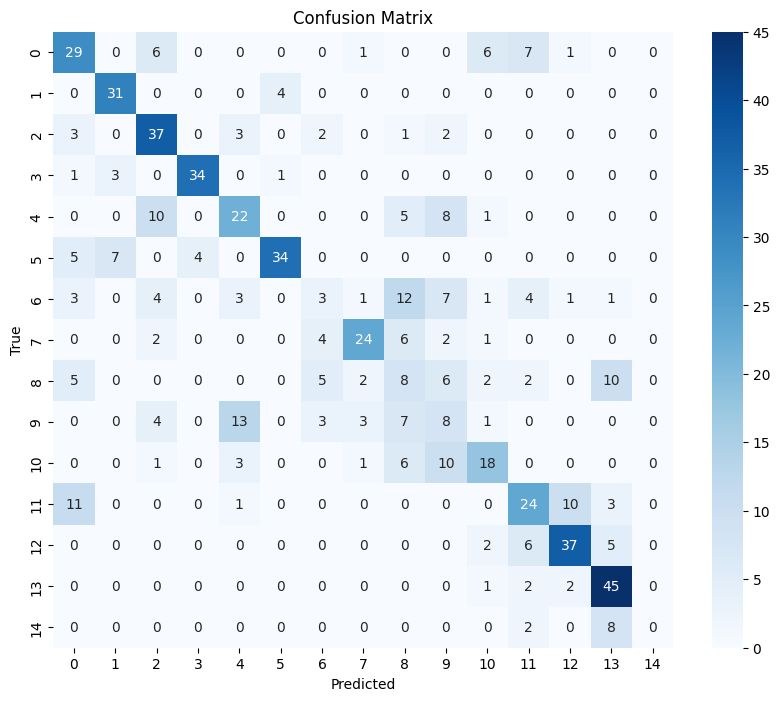

📁 Misclassified samples saved to: misclassified.csv
📁 Successed samples saved to: classified.csv


(56.73076923076923, 0.5536700088702078)

In [ ]:
save_evaluated_video(model, val_loader, plot_cm=True, save_misclassified=True)